<a href="https://colab.research.google.com/github/KulpitchaS/background-generator/blob/main/NeuralNetwork_intothewild_update%2002282024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Artificial Neural Networks

![](https://upload.wikimedia.org/wikipedia/commons/thumb/3/32/Single-layer_feedforward_artificial_neural_network.png/800px-Single-layer_feedforward_artificial_neural_network.png)
https://en.wikipedia.org/wiki/Artificial_neural_network

In a previous assignment, we met our first toy neural network. Here, we will adopt the neural network approach to analyze seismic reflection data.

## Data Loading

Let us start by loading seismic data.

In [ ]:
import os
import numpy as np

# The "seismic.bin" file is available from:
# https://utexas.box.com/s/bpyykirb1zu5y595r49jkzqvaxzb057r
# https://drive.google.com/file/d/1WwBG3hKfdD0UGdXEnbAjG7RnRU9eWkqU/view?usp=sharing

from google.colab import drive
drive.mount('/content/drive')
# change the directory name below to your local path
dirname = '/content/drive/MyDrive/'
#dirname = '/users/sergey/Downloads'

# Seismic data in raw binary format
filename = os.path.join(dirname, 'seismic.bin')

# memmap maps memory of the file on disk to a numpy array
nt, nx, ny = 2001, 1161, 601
seismic = np.memmap(filename, dtype=np.int16, shape=(ny, nx, nt))

Mounted at /content/drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
type(seismic)

numpy.memmap

In [ ]:
np.shape(seismic)

(601, 1161, 2001)

The seismic cube has coordinates (crossline, inline, time). Let us display one crossline section.

In [ ]:
import matplotlib.pyplot as plt

dt = 0.004  # time sampling in seconds
dx = 0.025  # trace sampling in kilometers


def plot_seismic(section):
    plt.imshow(section.T, cmap='gray', vmin=-2000, vmax=2000, aspect=0.5)
    xticks = np.arange(0, section.shape[0], 100)
    xtick_labels = [str(dx*k) for k in xticks]
    plt.xticks(ticks=xticks, labels=xtick_labels)
    plt.xlabel('distance (km)', fontsize=14)
    yticks = np.arange(0, section.shape[1], 250)
    ytick_labels = [str(dt*k) for k in yticks]
    plt.yticks(ticks=yticks, labels=ytick_labels)
    plt.ylabel('two-way traveltime (s)', fontsize=14)

In [ ]:
np.shape(seismic.T)

(2001, 1161, 601)

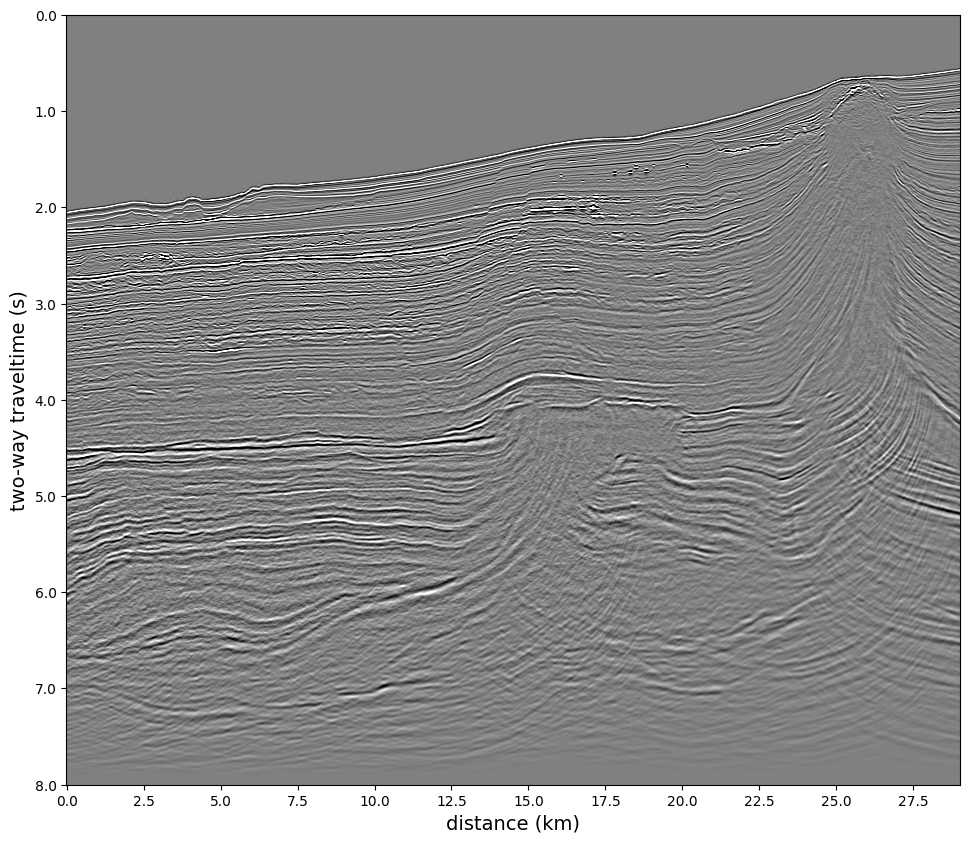

In [ ]:
plt.figure(figsize=(15, 10))
plot_seismic(seismic[300, :, :])
plt.show()

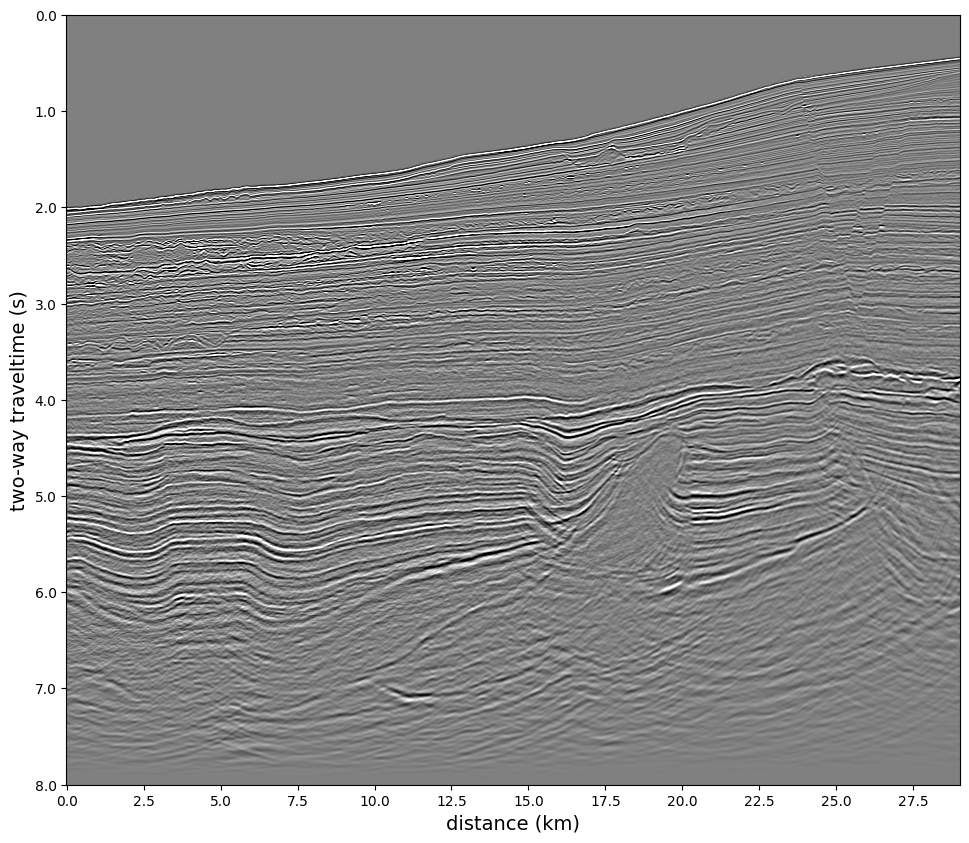

In [ ]:
plt.figure(figsize=(15, 10))
plot_seismic(seismic[500, :, :])
plt.show()

Seismic images like the ones above are created from reflection seismic recordings with an active source and represent the subsurface, in this case, under the Gulf of Mexico. Seismic interpretation aims to identify geologic objects in the image. In our first experiment, we will work with the simplest object: the seafloor horizon.

In [ ]:
import pandas as pd

url = 'https://raw.githubusercontent.com/zsylvester/GEO391_materials/master/FE_horizons/seafloor_XY_il_cl.csv'

df = pd.read_csv(url, names=['x', 'y', 'il', 'xl', 'z'])
df.tail()

x           y    il    xl           z
697693  405251.32  3234671.92  2030  7066  400.316566
697694  405269.58  3234689.00  2030  7067  399.911404
697695  405287.83  3234706.09  2030  7068  399.521232
697696  405306.09  3234723.17  2030  7069  399.086058
697697  405324.34  3234740.25  2030  7070  398.660868

In [ ]:
df.head()

x           y   il    xl            z
0  414187.21  3203316.25  870  6470  2119.056702
1  414205.46  3203333.33  870  6471  2118.776560
2  414223.72  3203350.41  870  6472  2118.410826
3  414241.97  3203367.50  870  6473  2117.910862
4  414260.23  3203384.58  870  6474  2117.447853

In [ ]:
min_il = df['il'].min()  # minimum inline number
max_il = df['il'].max()  # maximum inline number

min_xl = df['xl'].min()  # minimum crossline number
max_xl = df['xl'].max()  # maximum crossline number

# load horizon in a 2D numpy array
z = np.zeros((ny, nx))

il_ind = df['il'][:] - min_il
xl_ind = df['xl'][:] - min_xl
z[xl_ind, il_ind] = df['z'][:]

In [ ]:
z.shape

(601, 1161)

In [ ]:
# fill in the surface where there is no valid data:
zero_row, zero_col = np.where(z == 0)  # find locations where z = 0
for i in range(len(zero_row)):
    patch = z[zero_row[i] - 2: zero_row[i] + 3, zero_col[i] -
              2: zero_col[i] + 3]  # patch of 5x5 pixels
    # take the mean of nonzero neighbors
    z[zero_row[i], zero_col[i]] = np.mean(patch[patch != 0])

In [ ]:
zero_row

array([165, 167, 172, 176, 177, 182, 188, 188, 224, 225, 225, 228, 228,
       230, 233, 234, 236, 237, 238, 238, 239, 239, 240, 241, 241, 241,
       242, 244, 245, 245, 250, 250, 251, 251, 252, 256, 261, 264, 277,
       287, 287, 288, 288, 288, 288, 290, 291, 294, 294, 299, 299, 409,
       485, 517, 546, 551, 561, 562, 563, 575, 589, 595, 599])

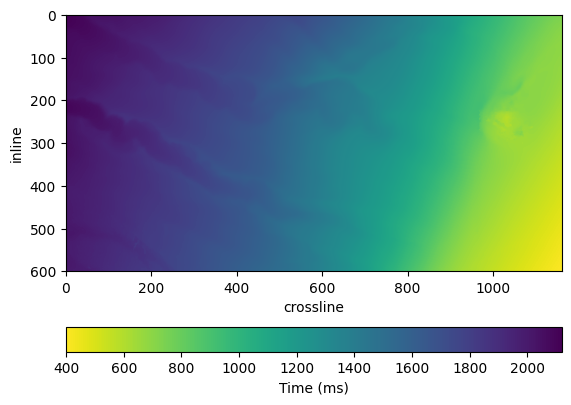

In [ ]:
plt.imshow(z, cmap='viridis_r')
plt.colorbar(orientation='horizontal', label='Time (ms)')
plt.xlabel('crossline')
plt.ylabel('inline')
plt.show()

To verify the horizon pick, let us display it on top of
a seismic section.

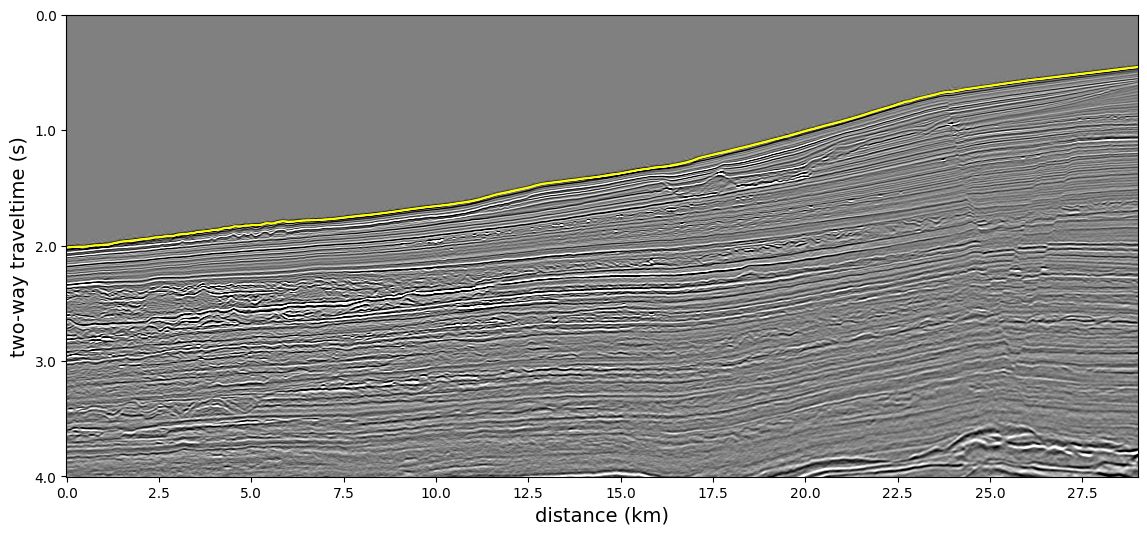

In [ ]:
def plot_section(xline):
    section = seismic[xline, :, :1001] # window top half - section was cut half here
    seafloor = z[xline, :]
    plt.figure(figsize=(15, 6))
    plot_seismic(section)
    plt.plot(seafloor/(dt*1000), color='yellow')
    plt.show()

plot_section(500)

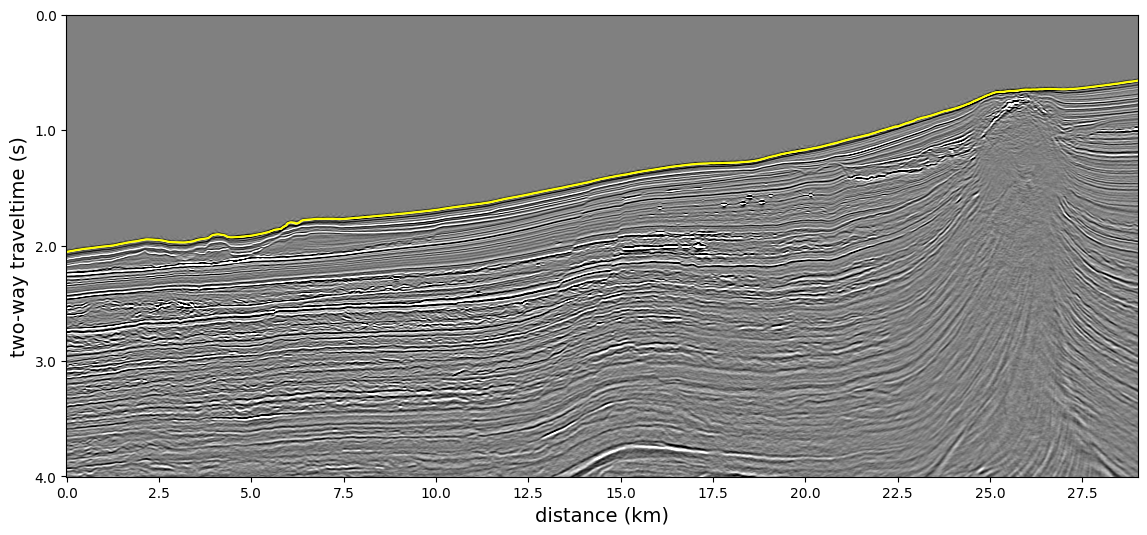

In [ ]:
plot_section(300)

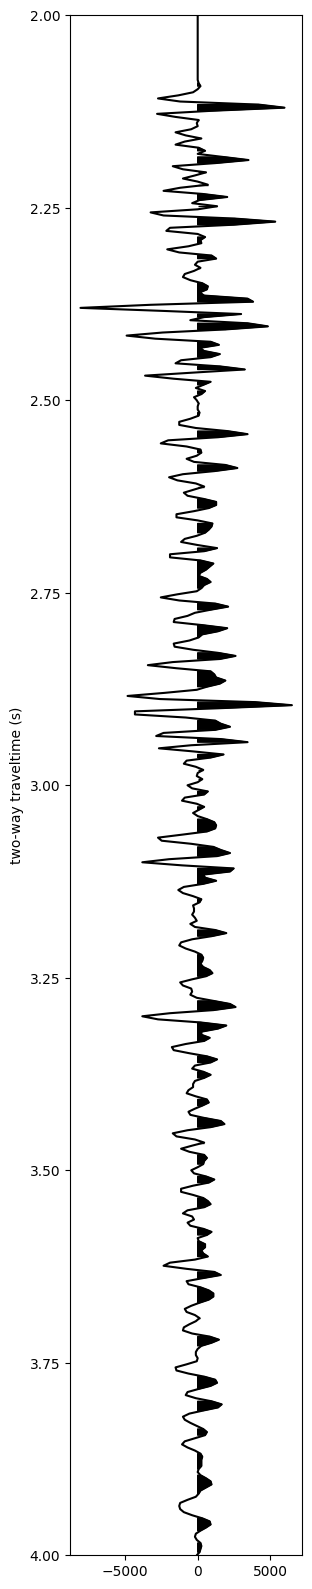

In [ ]:
# plot an individual trace

plt.figure(figsize=(3,20))
tr = seismic[0,0,:] # select 'first' trace in volume
twt = np.arange(0, nt) * dt
plt.plot(tr, twt, 'k')
# create variable-area display
plt.fill_betweenx(twt, tr,  0,  tr > 0.0,  color='k', alpha=1)
plt.ylim(2, 4)
plt.ylabel('two-way traveltime (s)')
plt.gca().invert_yaxis();

## Extracting Seismic Wavelets

Our goal is to teach the computer to pick a horizon automatically. To do that, we will extract seismic wavelets centered on the seafloor and compare them with wavelets from elsewhere in the section.

In [ ]:
# select one 2D section
section = seismic[500, :, :]
seafloor = z[500, :]

nw = 21  # set wavelet length

sf_wavelets = []
ntraces = len(seafloor)
for k in range(ntraces):
    trace = section[k, :]
    # convert miliseconds to index
    center = int(np.rint(seafloor[k] / (dt * 1000)))
    # extract wavelet centered at seafloor
    wavelet = trace[center-nw//2: center+nw//2+1]
    sf_wavelets.append(wavelet)

In [ ]:
np.shape(section) #section = seismic which slice ny at 500 >> get 2 plane x and z (nx, nt)

(1161, 2001)

In [ ]:
seafloor.shape #seafloor = time or depth (value in z) which slice at xline = 500 >> wil get inline and nt value of seabed

(1161,)

In [ ]:
center #center = value of seafloor in each index

113

In [ ]:
trace.shape #trace = value of nt in each nx (x plan)

(2001,)

In [ ]:
type(wavelet)

numpy.memmap

In [ ]:
len(sf_wavelets)

1161

Let us plot some seafloor wavelets to observe their shape.

In [ ]:
def plot_wavelets(wavelets, traces, title):
    nw = len(wavelets[0])
    ncols = len(traces)
    f, ax = plt.subplots(nrows=1, ncols=ncols, figsize=(16, 8))
    twt = np.arange(-nw//2+1, nw//2+1)*dt
    for trace in range(ncols):
        axt = ax[trace]
        # plot as curve
        amp = wavelets[traces[trace]]
        axt.plot(amp, twt, 'k')
        axt.set_ylim(twt.max(), twt.min())
        if trace == 0:
            axt.set_ylabel('Time (s)')
        else:
            axt.set_yticklabels([])
        axt.set_xticks([])
    f.suptitle(title, fontsize=25)
    plt.show()

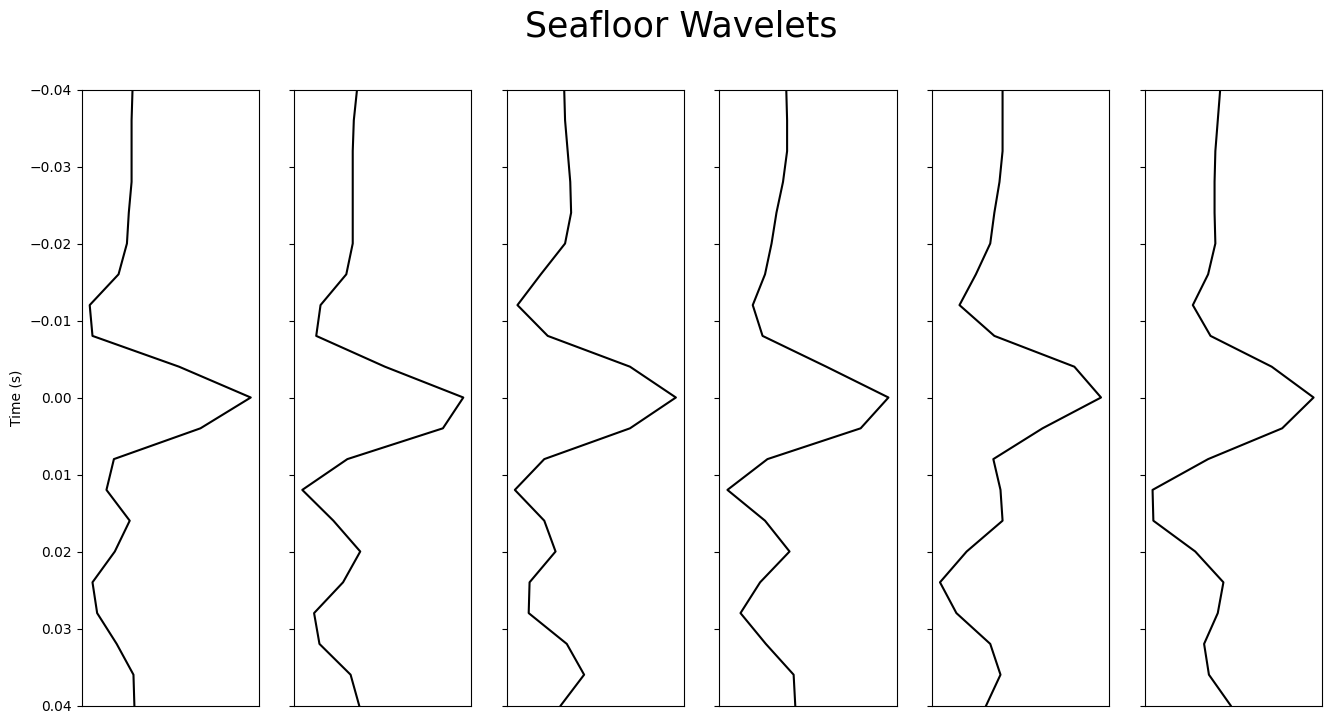

In [ ]:
plot_wavelets(sf_wavelets, np.arange(100, 601, 100),
             'Seafloor Wavelets')

We will also randomly extract wavelets from elsewhere in the section to train our model. For proper training, we will extract ten times more other wavelets.

In [ ]:
import random
random.seed(2024)

wavelets = []
cases = 10
for k in range(ntraces):
    trace = section[k, :]
    sf=int(np.rint(seafloor[k] / (dt * 1000)))
    for case in range(cases):
        # select center randomly
        center=random.randint(nw, nt-nw)
        # make sure it is not at the seafloor
        while center==sf:
            center=random.randint(nw, nt-nw)
        # extract wavelet
        wavelet=trace[center-nw//2: center+nw//2+1]
        wavelets.append(wavelet)

In [ ]:
len(wavelets)

11610

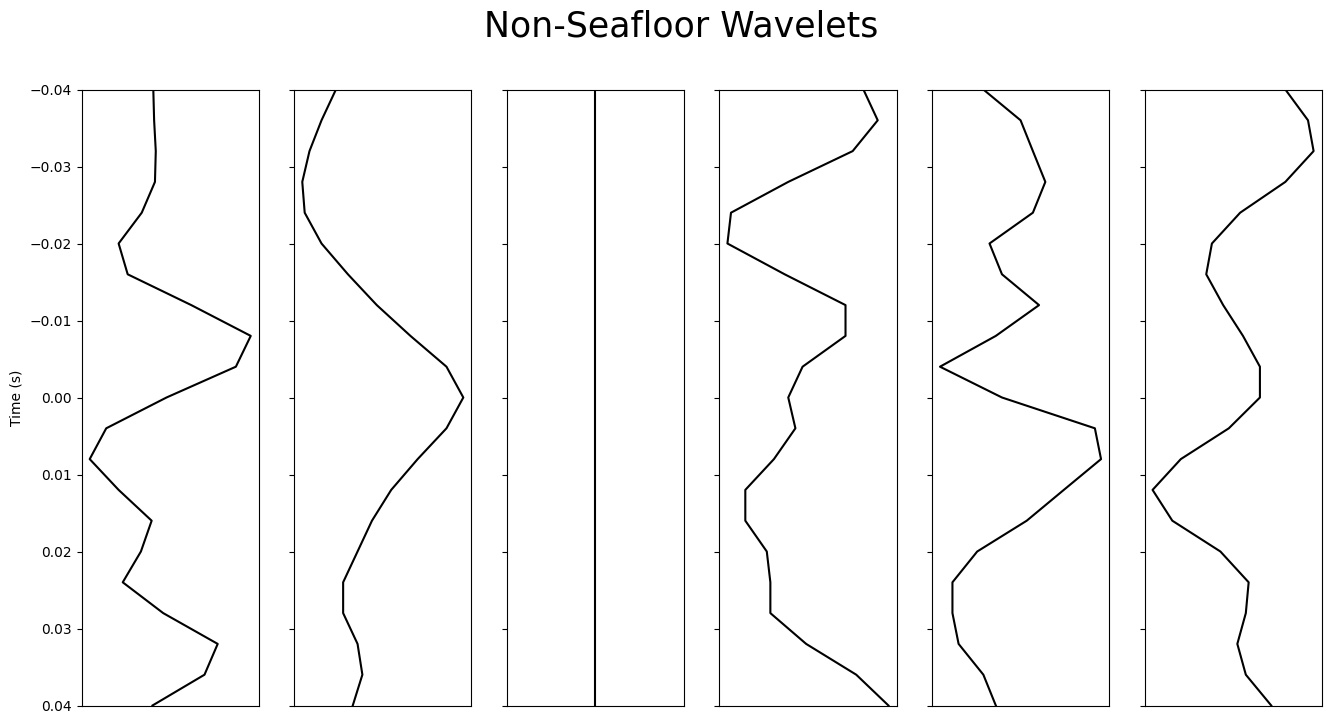

In [ ]:
plot_wavelets(wavelets, np.arange(100, 601, 100),
             'Non-Seafloor Wavelets')

A human can be easily trained to distinguish between seafloor and non-seafloor wavelets. To teach the computer to do that, we will build a model using neural networks.

## Python Packages for Deep Learning

As we saw previously, a simple neural network can be built using <code>MLPClassifier</code> from <code>sklearn</code> package. Several alternative open-source packages exist for more advanced methods and architectures.

![](https://upload.wikimedia.org/wikipedia/commons/thumb/a/ab/TensorFlow_logo.svg/640px-TensorFlow_logo.svg.png)

* [TensorFlow](https://www.tensorflow.org/) was initially developed by Google Brain, an artificial intelligence team at Google, and provides a powerful platform for designing, training, and applying machine-learning models.

![](https://keras.io/img/logo.png)

* [Keras](https://keras.io/) was built on top of TensorFlow to provide a simpler and more intuitive application programming interface (API) for common cases.

![](https://upload.wikimedia.org/wikipedia/commons/thumb/9/96/Pytorch_logo.png/800px-Pytorch_logo.png)

* [PyTorch](https://pytorch.org/) is an alternative platform developed by Facebook's AI Research lab (FAIR). Although its API is more verbose than the one in Keras, it is also more explicit in exposing the logic of machine learning.

In [ ]:
!pip install pytrends

In [ ]:
from pytrends.request import TrendReq

pytrend = TrendReq()
kw_list = ['TensorFlow', 'PyTorch', 'Keras']
pytrend.build_payload(kw_list, cat=32)  # 32: Software
interest = pytrend.interest_over_time()
interest.head()

TooManyRequestsError: The request failed: Google returned a response with code 429

In [ ]:
import matplotlib.pyplot as plt

interest.plot()
plt.title('Google Trends: Interest Over Time')
plt.show()

We will be using **Keras** in today's example.

## Designing a Neural Network

First, we will collect data from seafloor and non-seafloor wavelets.

In [ ]:
random.seed(2024)

all_wavelets = sf_wavelets+wavelets
random.shuffle(all_wavelets)
data = np.array(all_wavelets)
data.shape

(12771, 21)

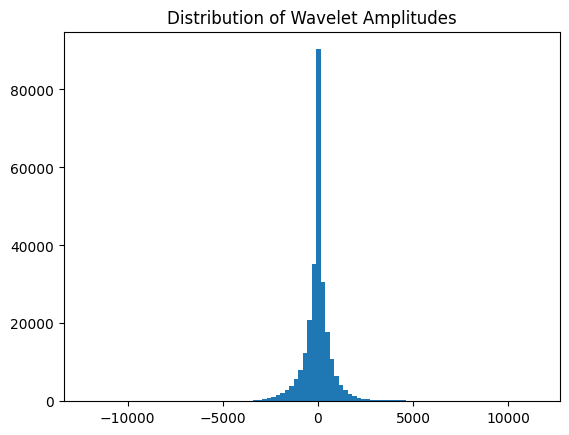

In [ ]:
plt.hist(data.flatten(), bins=100)
plt.title('Distribution of Wavelet Amplitudes')
plt.show()

In [ ]:
# normalize data
scale = 1.0/5000
data = data*scale
data

array([[ 0.0402,  0.0504,  0.0504, ..., -0.0302,  0.01  ,  0.0604],
       [ 0.    ,  0.    ,  0.    , ..., -0.4538, -0.1578,  0.1184],
       [ 0.2588,  0.3278,  0.3192, ...,  0.3796,  0.414 ,  0.3708],
       ...,
       [ 0.0636,  0.0478,  0.0398, ..., -0.0636, -0.0636, -0.0636],
       [ 0.0282,  0.066 ,  0.0564, ..., -0.0754, -0.0848, -0.0942],
       [-0.054 , -0.054 , -0.054 , ...,  0.027 ,  0.027 ,  0.    ]])

We will label seafloor wavelets as 1 and non-seafloor wavelets as 0 for training.

In [ ]:
random.seed(2024)

indicators = [1]*len(sf_wavelets)+[0]*len(wavelets)
random.shuffle(indicators)
labels = np.array(indicators)
labels.shape

(12771,)

Our network will contain one hidden layer, transferring its output to classification.

In [ ]:
from tensorflow import keras
import tensorflow.random

# for reproducibility
tensorflow.random.set_seed(2024)
np.random.seed(2024)

model = keras.Sequential(
    [
        keras.Input(shape=(nw,)),
        keras.layers.Dense(8, activation='relu'),
        keras.layers.Dense(1, activation='sigmoid'),
    ]
)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8)                 176       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 185 (740.00 Byte)
Trainable params: 185 (740.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Mathematically, the model can be represented as follows:

$$y = s\left(a_2 + \mathbf{b}_2^{T}\,r\left(\mathbf{a}_1 + \mathbf{B}_1^{T}\,\mathbf{x}\right)\right)\;.$$

Here $\mathbf{x}$ is an input (21-dimensional vector), and $y$ is a scalar output (probability of seafloor).

The network sandwiches linear and non-linear operations. The non-linear activation functions are $r(z)$ for ReLU and $s(z)$ for sigmoid.

The parameters of the model are $\mathbf{B}_1$ ($21 \times 8$ matrix), $\mathbf{a}_1$ (8-dimensional vector), $\mathbf{b}_2$ (8-dimensional vector), and $a_2$ (a scalar). The total number of parameters is
$$21 \times 8 + 8 + 8 + 1 = 185\;.$$

In [ ]:
21*8+8+8+1

185

To train the model, we will ask it to use the Adam optimizer and the cross-entropy loss function. We will also ask it to track the prediction accuracy (the percentage of accurate predictions).

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

## Training the Model

We need to apply weighting to avoid bias because we have only a few seafloor wavelets compared to the number of other wavelets.

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight('balanced', classes=[0,1], y=labels)
class_weights = dict(enumerate(class_weights))
print(class_weights)

{0: 0.55, 1: 5.5}


Finally, we are ready to train the model. Note that Keras handles splitting the data into training and validation internally during training.

In [ ]:
# fit the model
batch_size=20
epochs=15
fit = model.fit(data,labels,
                batch_size=batch_size,
                epochs=epochs,
                class_weight=class_weights,
                validation_split=0.3)

Epoch 1/15
447/447 [==============================] - 3s 3ms/step - loss: 0.4398 - accuracy: 0.9456 - val_loss: 0.1597 - val_accuracy: 0.9896
Epoch 2/15
447/447 [==============================] - 1s 3ms/step - loss: 0.0812 - accuracy: 0.9940 - val_loss: 0.0464 - val_accuracy: 0.9935
Epoch 3/15
447/447 [==============================] - 1s 3ms/step - loss: 0.0289 - accuracy: 0.9952 - val_loss: 0.0281 - val_accuracy: 0.9935
Epoch 4/15
447/447 [==============================] - 1s 3ms/step - loss: 0.0176 - accuracy: 0.9956 - val_loss: 0.0215 - val_accuracy: 0.9940
Epoch 5/15
447/447 [==============================] - 1s 2ms/step - loss: 0.0130 - accuracy: 0.9960 - val_loss: 0.0178 - val_accuracy: 0.9950
Epoch 6/15
447/447 [==============================] - 1s 3ms/step - loss: 0.0105 - accuracy: 0.9965 - val_loss: 0.0167 - val_accuracy: 0.9956
Epoch 7/15
447/447 [==============================] - 1s 3ms/step - loss: 0.0089 - accuracy: 0.9970 - val_loss: 0.0155 - val_accuracy: 0.9958
Epoch 

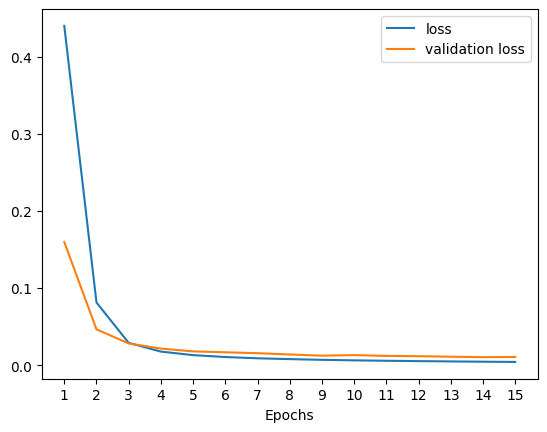

In [ ]:
def plot_loss(fit, epochs):
    iterations = np.arange(1, epochs+1)
    plt.plot(iterations, fit.history['loss'], label='loss')
    plt.plot(iterations, fit.history['val_loss'], label='validation loss')
    plt.legend()
    plt.xticks(iterations[::epochs//10])
    plt.xlabel('Epochs')
    plt.show()


plot_loss(fit, epochs)

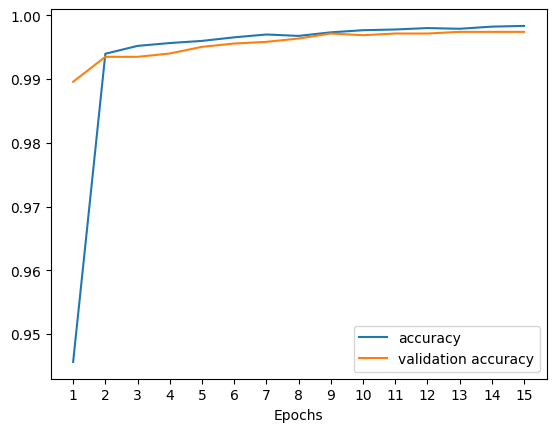

In [ ]:
def plot_accuracy(fit, epochs):
    iterations = np.arange(1, epochs+1)
    plt.plot(iterations, fit.history['accuracy'], label='accuracy')
    plt.plot(iterations, fit.history['val_accuracy'],
             label='validation accuracy')
    plt.legend()
    #plt.ylim(0.7, 1.0)
    plt.xticks(iterations[::epochs//10])
    plt.xlabel('Epochs')
    plt.show()


plot_accuracy(fit, epochs)

In [ ]:
#Save original model
keras.models.save_model(model, 'model.h5', save_format='h5')

<ipython-input-47-0e66e72f0c49>:2: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  keras.models.save_model(model, 'model.h5', save_format='h5')


As we expect, the loss decreases, and the accuracy increases with iterations.

The fact that training is slightly more accurate than validation might indicate the problem of *overfitting*, which happens when the model is tuned too much to match training data while failing to pick a more general pattern.

## Overcoming Overfitting: Dropout

A simple way to address the overfitting problem is *dropout*: randomly dropping out a portion of "neurons" during the training process.

* Srivastava, N., Hinton, G., Krizhevsky, A., Sutskever, I. and Salakhutdinov, R., 2014. [Dropout: a simple way to prevent neural networks from overfitting](https://www.jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf). The Journal of Machine Learning Research, 15(1), pp.1929-1958.

Let us redefine our model to include a dropout layer.

In [ ]:
drop = 0.1  # drop out 10% of neurons

model2 = keras.Sequential(
    [
        keras.Input(shape=(nw,)),
        keras.layers.Dense(8, activation='relu'),
        keras.layers.Dropout(drop),
        keras.layers.Dense(1, activation='sigmoid'),
    ]
)

In [ ]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 8)                 176       
                                                                 
 dropout (Dropout)           (None, 8)                 0         
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 185 (740.00 Byte)
Trainable params: 185 (740.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model2.compile(loss='binary_crossentropy',
               optimizer='adam',
               metrics=['accuracy'])

In [ ]:
# fit the model
batch_size=20
epochs=15
fit2 = model2.fit(data,labels,
                  batch_size=batch_size,
                  epochs=epochs,
                  class_weight=class_weights,
                  validation_split=0.3)

Epoch 1/15
447/447 [==============================] - 2s 3ms/step - loss: 0.3683 - accuracy: 0.8190 - val_loss: 0.2934 - val_accuracy: 0.9718
Epoch 2/15
447/447 [==============================] - 2s 4ms/step - loss: 0.1100 - accuracy: 0.9850 - val_loss: 0.0871 - val_accuracy: 0.9901
Epoch 3/15
447/447 [==============================] - 2s 5ms/step - loss: 0.0459 - accuracy: 0.9922 - val_loss: 0.0438 - val_accuracy: 0.9916
Epoch 4/15
447/447 [==============================] - 1s 3ms/step - loss: 0.0279 - accuracy: 0.9935 - val_loss: 0.0306 - val_accuracy: 0.9932
Epoch 5/15
447/447 [==============================] - 1s 3ms/step - loss: 0.0216 - accuracy: 0.9943 - val_loss: 0.0259 - val_accuracy: 0.9930
Epoch 6/15
447/447 [==============================] - 1s 3ms/step - loss: 0.0177 - accuracy: 0.9952 - val_loss: 0.0212 - val_accuracy: 0.9940
Epoch 7/15
447/447 [==============================] - 1s 3ms/step - loss: 0.0148 - accuracy: 0.9946 - val_loss: 0.0194 - val_accuracy: 0.9945
Epoch 

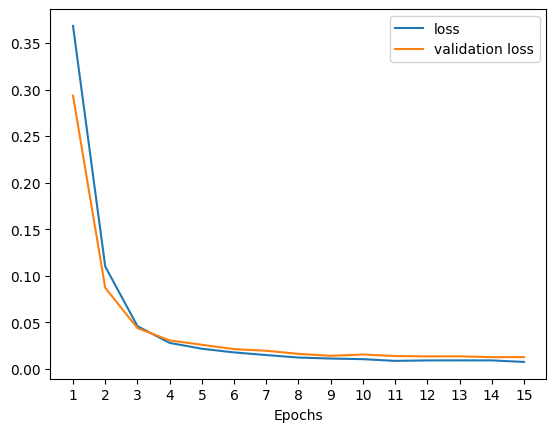

In [ ]:
plot_loss(fit2,epochs)

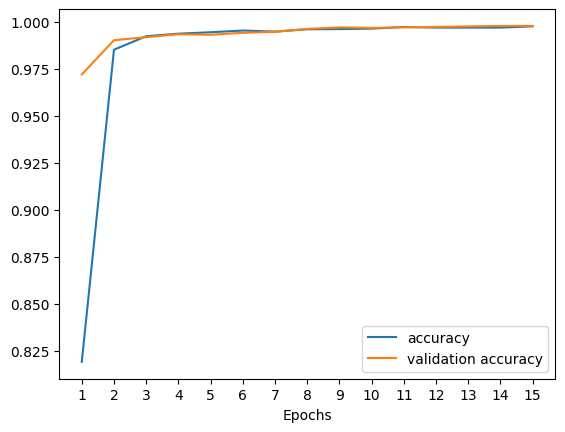

In [ ]:
plot_accuracy(fit2,epochs)

In [ ]:
#Save model2 - drop 10%
keras.models.save_model(model2, 'model2.h5', save_format='h5')

<ipython-input-54-3e609b49cfcd>:2: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  keras.models.save_model(model2, 'model2.h5', save_format='h5')


## Checking Prediction Accuracy

In [ ]:
# predicting probabilities
pred = model2.predict(data)
print(pred)

400/400 [==============================] - 1s 1ms/step
[[7.5433571e-05]
 [9.9396437e-01]
 [2.7582659e-05]
 ...
 [9.1030059e-05]
 [8.9904359e-05]
 [4.5021447e-05]]


Let us find examples of mis-identified wavelets.

In [ ]:
false = np.nonzero(np.rint(pred[:,0]) != labels)
print(false)

(array([  737,  1325,  2096,  2115,  2577,  3372,  4512,  4708,  5047,
        5587,  5730,  7135,  7154,  7373,  7887,  8573,  8605,  8626,
        9147,  9270,  9824, 10275, 10625, 10953, 11603, 11919, 12044]),)


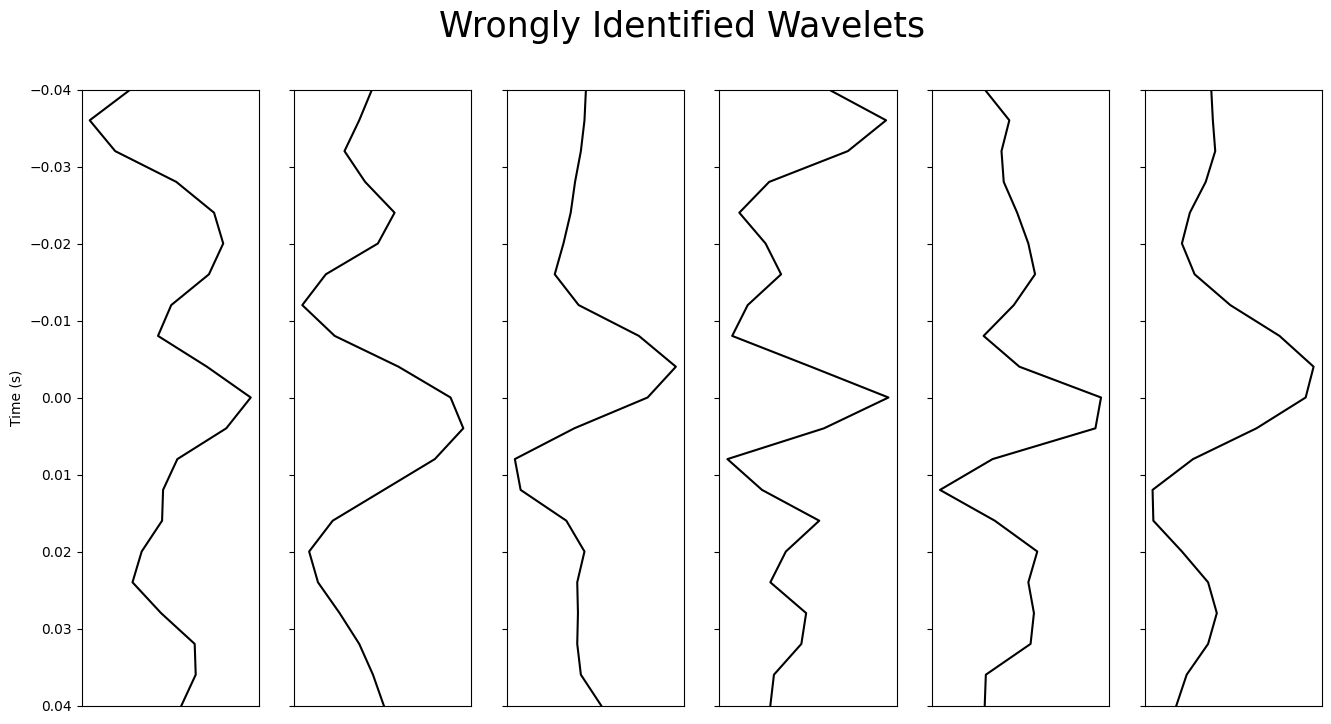

In [ ]:
plot_wavelets(list(data),false[0][1:7],
             'Wrongly Identified Wavelets')

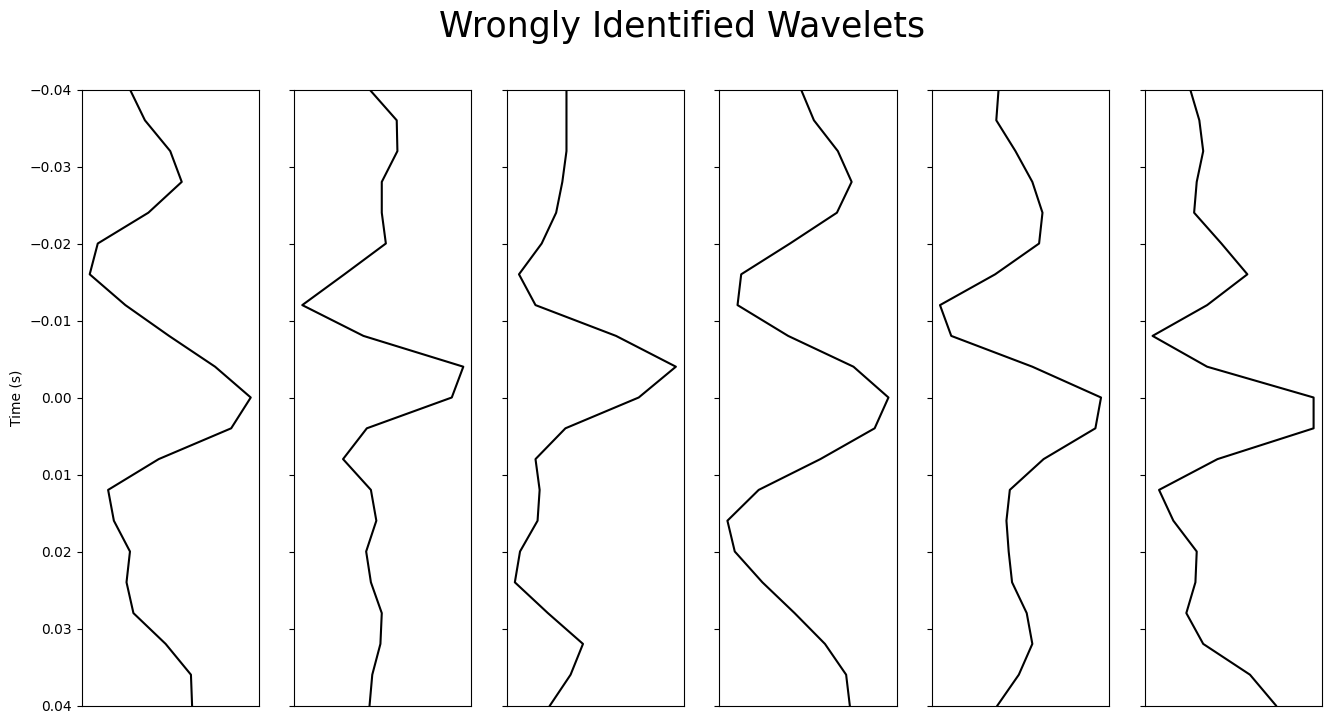

In [ ]:
plot_wavelets(list(data),false[0][7:13],
             'Wrongly Identified Wavelets')

In [ ]:
pred[false[0][7:13]]

array([[0.7581594 ],
       [0.99999547],
       [0.8480273 ],
       [0.9035546 ],
       [0.79570186],
       [0.9200292 ]], dtype=float32)

## Checking Model Parameters

To try to understand the internal structure of the neural network, we can also display model parameters.

In the hidden layer, the main parameters are contained in the $\mathbf{B}_1$ matrix:

$$y = s\left(a_2 + \mathbf{b}_2^{T}\,r\left(\mathbf{a}_1 + \mathbf{B}_1^{T}\,\mathbf{x}\right)\right)\;.$$

In [ ]:
# Print the number of layers in the model
print(f"Number of layers: {len(model2.layers)}")

Number of layers: 3


In [ ]:
weights,intercepts = model2.layers[0].get_weights() #Get weight just the first layer
len(weights)

21

In [ ]:
weights=np.array(weights)
weights.shape

(21, 8)

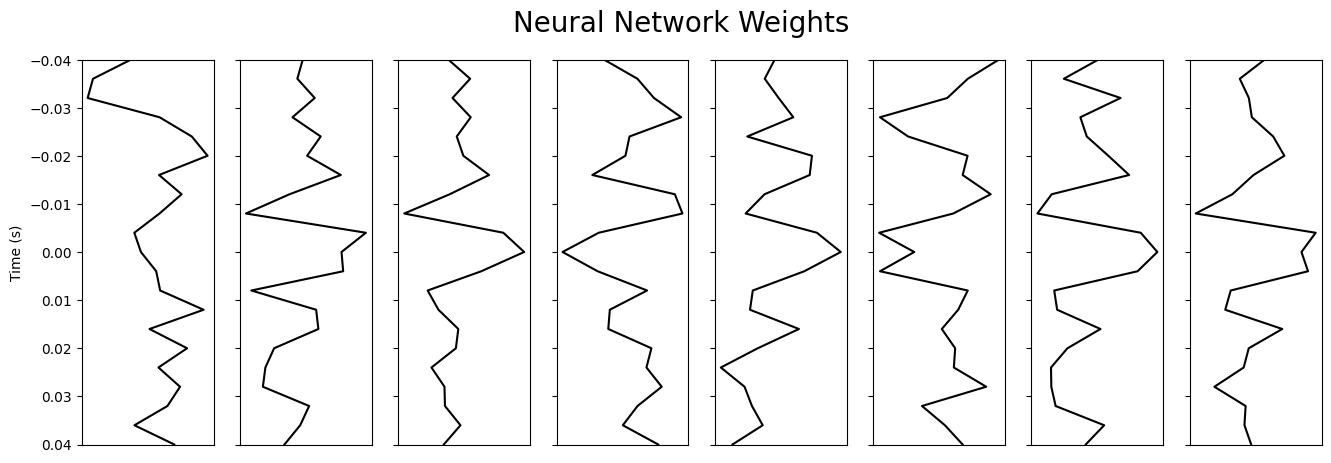

In [ ]:
f, ax = plt.subplots(nrows=1,ncols=8,figsize=(16,5))
twt = np.arange(-nw//2+1,nw//2+1)*dt
for trace in range(8):
    axt = ax[trace]
    # plot as curve
    amp=weights[:,trace]
    axt.plot(amp,twt,'k')
    axt.set_ylim(twt.max(),twt.min())
    if trace == 0:
        axt.set_ylabel('Time (s)')
    else:
        axt.set_yticklabels([])
    axt.set_xticks([])
f.suptitle('Neural Network Weights',fontsize=20)
plt.show()

## Application to Seafloor Picking

We trained our model on one section out of the 3D seismic cube. We can now try to apply it to other sections to pick the seafloor horizon automatically.

In [ ]:
from scipy.signal import find_peaks

sections = seismic[400, :, :1001] #This is the place where section was reset to 1001 instead of 2001 in originally. I change parameter to seismic

pick = np.zeros(ntraces)
for k in range(ntraces):
    trace = sections[k, :]
    # find local maxima
    peaks, _ = find_peaks(np.abs(trace))
    test_wavelets = []
    for peak in peaks:
        if peak > nw and peak < 1001-nw:
            wavelet = trace[peak-nw//2:peak+nw//2+1]
            test_wavelets.append(wavelet)
    # normalize
    test_wavelets = np.array(test_wavelets)*scale
    # get probabilities
    pred = model2.predict(test_wavelets)
    # select the highest probability
    best = np.argmax(pred)
    pick[k] = peaks[best]

7/7 [==============================] - 0s 3ms/step


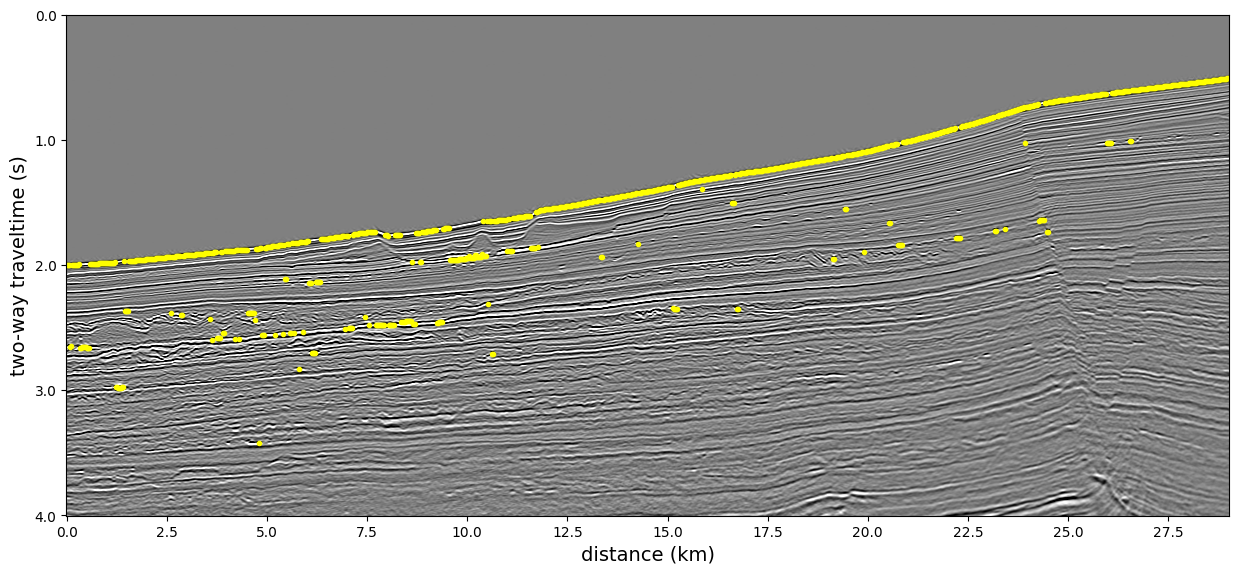

In [ ]:
plt.figure(figsize=(15, 10))
plot_seismic(sections)
plt.plot(pick, color='yellow', marker='.', linestyle='None')
plt.show()

## <span style="color:red">Task 1</span>

There are several ways to improve the results.

1. Use better training data.

For example:

- Find the parameter responsible for the length of the wavelet. Does it help to increase it from 21 to 41?
- Find the parameter responsible for scaling the wavelet amplitude. Does it help to change it from 1/5000 to a different number?

2. Use more training data.

For example:

- Generate more cases of non-seafloor wavelets by increasing the parameter called <code>cases</code>.
- Collect seafloor and non-seafloor wavelets for training from more than one section.

3. Change the model definition.

For example:

- Does it help to change the output size in the hidden layer? Should it be increased or decreased?
- Does it help to add more layers to the network?

<div class="alert alert-info">
You can save a previously generated and trained model in a file using
    
<code>keras.models.save_model(model, 'model.h5', save_format='h5')</code>
    
In this case, the file format is HDF-5 (Hierarchical Data Format).
    
Load the model back with
    
<code>model = keras.models.load_model('model.h5')</code>
    
Reset Keras memory for generating and training a new model using

<code>keras.backend.clear_session()</code>
</div>

4. Change optimization parameters.

For example:

- Does it help to change the learning rate in the Adam optimizer?
- Does it help to change the batch size?

The list of **Keras** optimizers and their parameters is available at https://keras.io/api/optimizers/.

In [ ]:
keras.optimizers.Adam?

* Kingma, D.P. and Ba, J., 2014. Adam: A method for stochastic optimization. arXiv preprint [arXiv:1412.6980](https://arxiv.org/abs/1412.6980).

![](https://i.stack.imgur.com/3vZUJ.png)

<span style="color:red">Out of this long list of possibilities, pick two from two different categories and try them out.</span>

First option: Try use more training data, cases change from 10 to 100

In [ ]:
# Try use more training data, cases change from 10 to 100

import random
random.seed(2024)

section = seismic[500, :, :]
wavelets2 = []
cases = 100
lengths = []
for k in range(ntraces):
    trace = section[k, :]
    sf=int(np.rint(seafloor[k] / (dt * 1000)))
    for case in range(cases):
        # select center randomly
        center=random.randint(nw, nt-nw)
        # make sure it is not at the seafloor
        while center==sf:
            center=random.randint(nw, nt-nw)
        # extract wavelet
        wavelet=trace[center-nw//2: center+nw//2+1]
        wavelets2.append(wavelet)
        # if len(wavelet) < 21:
        #   print(center, k)
        #   break

In [ ]:
section.shape

(1161, 2001)

In [ ]:
np.shape(np.array(wavelets2))

(116100, 21)

In [ ]:
random.seed(2024)

all_wavelets2 = sf_wavelets+wavelets2
random.shuffle(all_wavelets2)

# Filter out elements with different shapes
#filtered_wavelets = [element for element in all_wavelets2 if element.shape == all_wavelets2[0].shape]

# Convert the filtered list to a NumPy array
#data2 = np.array(filtered_wavelets)
data2 = np.array(all_wavelets2)
data2.shape

(117261, 21)

In [ ]:
len(all_wavelets2)

117261

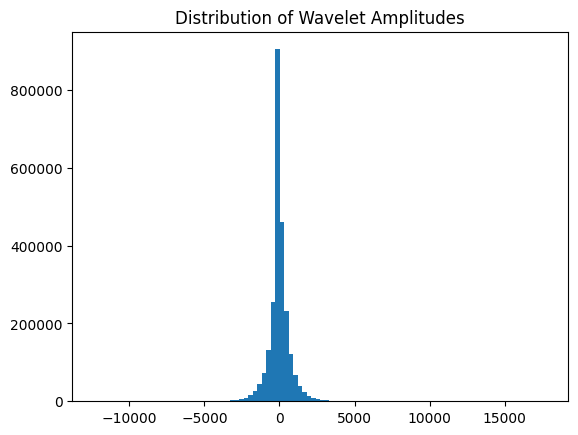

In [ ]:
plt.hist(data2.flatten(), bins=100)
plt.title('Distribution of Wavelet Amplitudes')
plt.show()

In [ ]:
# normalize data
min = data2.min()
max = data2.max()
data2 = (data2-min)/(max-min)
data2

array([[0.41389074, 0.41499001, 0.41389074, ..., 0.410493  , 0.41162558,
        0.41389074],
       [0.40319787, 0.4062958 , 0.41858761, ..., 0.40936043, 0.4062958 ,
        0.39860093],
       [0.40582945, 0.38997335, 0.37941372, ..., 0.45516322, 0.43401066,
        0.40056629],
       ...,
       [0.41402398, 0.41402398, 0.41402398, ..., 0.40819454, 0.41052632,
        0.41402398],
       [0.40936043, 0.40936043, 0.40936043, ..., 0.40936043, 0.40936043,
        0.40936043],
       [0.38664224, 0.38827448, 0.38827448, ..., 0.46612258, 0.45962692,
        0.45153231]])

In [ ]:
data2.shape

(117261, 21)

In [ ]:
#Set indicator
random.seed(2024)

indicators2 = [1]*len(sf_wavelets)+[0]*len(wavelets2)
random.shuffle(indicators2)
labels2 = np.array(indicators2)
labels2.shape

(117261,)

In [ ]:
#Set the model
# for reproducibility
tensorflow.random.set_seed(2024)
np.random.seed(2024)

model_task1_1 = keras.Sequential(
    [
        keras.Input(shape=(nw,)),
        keras.layers.Dense(8, activation='relu'),
        keras.layers.Dense(1, activation='sigmoid'),
    ]
)

In [ ]:
#Complie the model
model_task1_1.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
#Use the original model to retrain and fit the model
class_weights = compute_class_weight('balanced', classes=[0,1], y=labels2)
class_weights = dict(enumerate(class_weights))
print(class_weights)

batch_size=20
epochs=15
fit_task1_1 = model.fit(data2,labels2,
                batch_size=batch_size,
                epochs=epochs,
                class_weight=class_weights,
                validation_split=0.3)

{0: 0.505, 1: 50.5}
Epoch 1/15
4105/4105 [==============================] - 13s 3ms/step - loss: 0.3690 - accuracy: 0.9979 - val_loss: 0.1170 - val_accuracy: 0.9966
Epoch 2/15
4105/4105 [==============================] - 12s 3ms/step - loss: 0.1238 - accuracy: 0.9971 - val_loss: 0.0283 - val_accuracy: 0.9970
Epoch 3/15
4105/4105 [==============================] - 13s 3ms/step - loss: 0.0503 - accuracy: 0.9963 - val_loss: 0.0268 - val_accuracy: 0.9943
Epoch 4/15
4105/4105 [==============================] - 14s 3ms/step - loss: 0.0243 - accuracy: 0.9959 - val_loss: 0.0108 - val_accuracy: 0.9966
Epoch 5/15
4105/4105 [==============================] - 11s 3ms/step - loss: 0.0157 - accuracy: 0.9960 - val_loss: 0.0128 - val_accuracy: 0.9958
Epoch 6/15
4105/4105 [==============================] - 11s 3ms/step - loss: 0.0119 - accuracy: 0.9963 - val_loss: 0.0064 - val_accuracy: 0.9977
Epoch 7/15
4105/4105 [==============================] - 12s 3ms/step - loss: 0.0108 - accuracy: 0.9961 - val_l

In [ ]:
print(type(fit_task1_1))

<class 'keras.src.callbacks.History'>


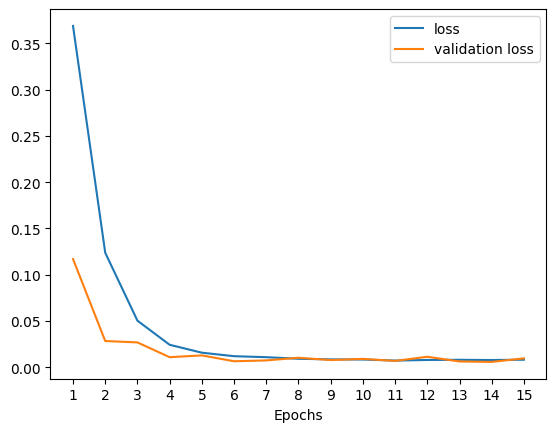

In [ ]:
#Plot model loss
plot_loss(fit_task1_1, epochs)

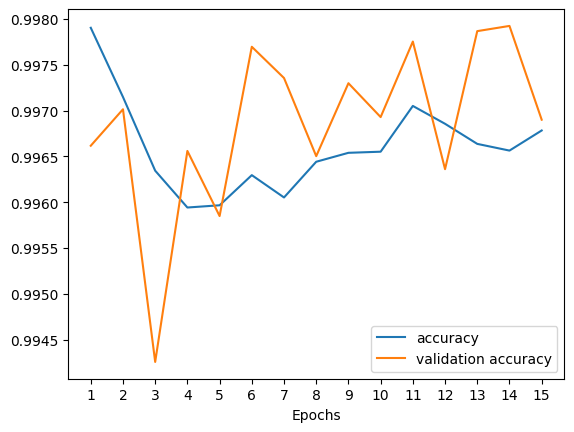

In [ ]:
#Plot model accuracy
plot_accuracy(fit_task1_1, epochs)

Second options: Change the output size in the hidden layer? Should it be increased or decreased?

model_task1_21: increase output layer size from 8 to 15

model_task1_22: decrease output layer size from 8 to 4

model_task1_23: add more layer to nueral network (n=8, n=4)

model_task1_31: change adam learning rate from 0.001 (default) to 0.005

Use original data (case = 10) instead of case 100

In [ ]:
len(data)

12771

In [ ]:
#Set the model_task1_21
# for reproducibility
tensorflow.random.set_seed(2024)
np.random.seed(2024)

model_task1_21 = keras.Sequential(
    [
        keras.Input(shape=(nw,)),
        keras.layers.Dense(15, activation='relu'),
        keras.layers.Dense(1, activation='sigmoid'),
    ]
)

In [ ]:
model_task1_21.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 15)                330       
                                                                 
 dense_7 (Dense)             (None, 1)                 16        
                                                                 
Total params: 346 (1.35 KB)
Trainable params: 346 (1.35 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
#Complie the model
model_task1_21.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
# fit the model
batch_size=20
epochs=15
fit_task1_21 = model_task1_21.fit(data,labels,
                batch_size=batch_size,
                epochs=epochs,
                class_weight=class_weights,
                validation_split=0.3)

Epoch 1/15
447/447 [==============================] - 2s 3ms/step - loss: 1.5575 - accuracy: 0.4367 - val_loss: 0.4706 - val_accuracy: 0.8946
Epoch 2/15
447/447 [==============================] - 1s 3ms/step - loss: 0.1890 - accuracy: 0.9623 - val_loss: 0.1162 - val_accuracy: 0.9817
Epoch 3/15
447/447 [==============================] - 1s 3ms/step - loss: 0.0628 - accuracy: 0.9872 - val_loss: 0.0594 - val_accuracy: 0.9888
Epoch 4/15
447/447 [==============================] - 1s 3ms/step - loss: 0.0351 - accuracy: 0.9907 - val_loss: 0.0416 - val_accuracy: 0.9909
Epoch 5/15
447/447 [==============================] - 1s 3ms/step - loss: 0.0247 - accuracy: 0.9922 - val_loss: 0.0325 - val_accuracy: 0.9927
Epoch 6/15
447/447 [==============================] - 2s 5ms/step - loss: 0.0195 - accuracy: 0.9934 - val_loss: 0.0298 - val_accuracy: 0.9930
Epoch 7/15
447/447 [==============================] - 2s 4ms/step - loss: 0.0164 - accuracy: 0.9945 - val_loss: 0.0264 - val_accuracy: 0.9937
Epoch 

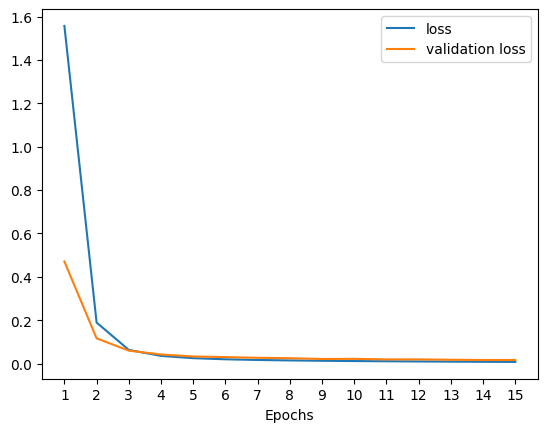

In [ ]:
#Plot model loss
plot_loss(fit_task1_21, epochs)

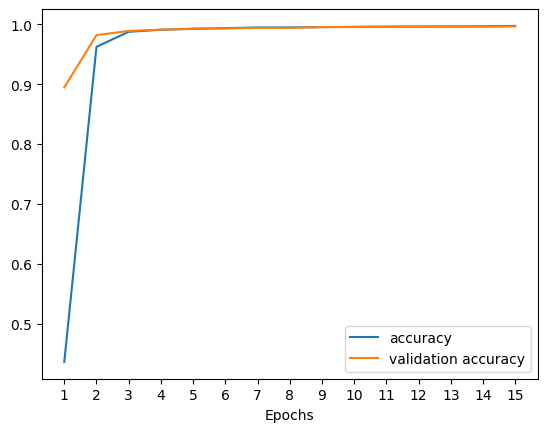

In [ ]:
#Plot model accuracy
plot_accuracy(fit_task1_21, epochs)

In [ ]:
#Set the model_task1_22
# for reproducibility
tensorflow.random.set_seed(2024)
np.random.seed(2024)

model_task1_22 = keras.Sequential(
    [
        keras.Input(shape=(nw,)),
        keras.layers.Dense(4, activation='relu'),
        keras.layers.Dense(1, activation='sigmoid'),
    ]
)

In [ ]:
#Complie the model
model_task1_22.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
# fit the model
batch_size=20
epochs=15
fit_task1_22 = model_task1_22.fit(data,labels,
                batch_size=batch_size,
                epochs=epochs,
                class_weight=class_weights,
                validation_split=0.3)

Epoch 1/15
447/447 [==============================] - 3s 4ms/step - loss: 1.1286 - accuracy: 0.0932 - val_loss: 0.9540 - val_accuracy: 0.0869
Epoch 2/15
447/447 [==============================] - 1s 3ms/step - loss: 0.5097 - accuracy: 0.1864 - val_loss: 0.7644 - val_accuracy: 0.5551
Epoch 3/15
447/447 [==============================] - 1s 3ms/step - loss: 0.3914 - accuracy: 0.7202 - val_loss: 0.6400 - val_accuracy: 0.8285
Epoch 4/15
447/447 [==============================] - 1s 3ms/step - loss: 0.3179 - accuracy: 0.8748 - val_loss: 0.5330 - val_accuracy: 0.9108
Epoch 5/15
447/447 [==============================] - 1s 3ms/step - loss: 0.2593 - accuracy: 0.9323 - val_loss: 0.4395 - val_accuracy: 0.9442
Epoch 6/15
447/447 [==============================] - 1s 3ms/step - loss: 0.2114 - accuracy: 0.9578 - val_loss: 0.3606 - val_accuracy: 0.9632
Epoch 7/15
447/447 [==============================] - 1s 3ms/step - loss: 0.1724 - accuracy: 0.9725 - val_loss: 0.2970 - val_accuracy: 0.9713
Epoch 

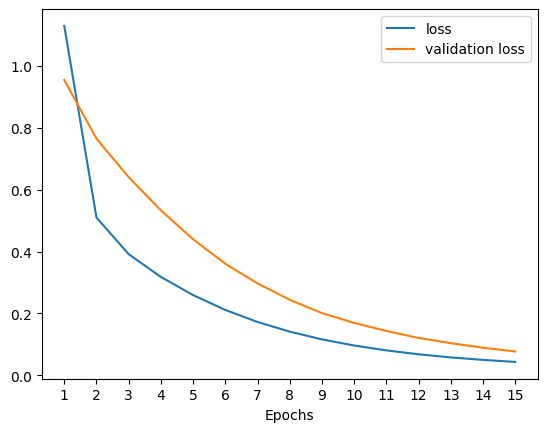

In [ ]:
#Plot model loss
plot_loss(fit_task1_22, epochs)

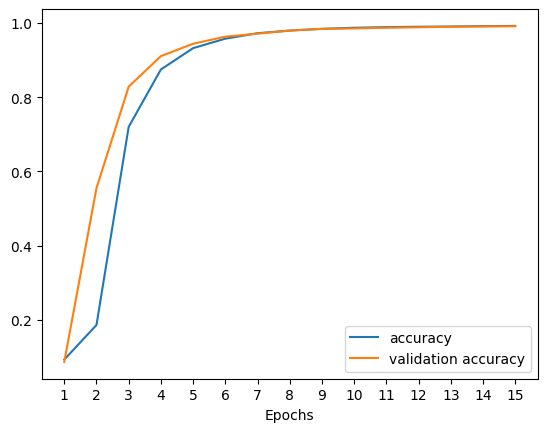

In [ ]:
#Plot model accuracy
plot_accuracy(fit_task1_22, epochs)

In [ ]:
#Set the model_task1_23
# for reproducibility
tensorflow.random.set_seed(2024)
np.random.seed(2024)

model_task1_23 = keras.Sequential(
    [
        keras.Input(shape=(nw,)),
        keras.layers.Dense(8, activation='relu'),
        keras.layers.Dense(4, activation='relu'),
        keras.layers.Dense(1, activation='sigmoid'),
    ]
)

In [ ]:
model_task1_23.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 8)                 176       
                                                                 
 dense_11 (Dense)            (None, 4)                 36        
                                                                 
 dense_12 (Dense)            (None, 1)                 5         
                                                                 
Total params: 217 (868.00 Byte)
Trainable params: 217 (868.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model_task1_23.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
# fit the model
batch_size=20
epochs=15
fit_task1_23 = model_task1_23.fit(data,labels,
                batch_size=batch_size,
                epochs=epochs,
                class_weight=class_weights,
                validation_split=0.3)

Epoch 1/15
447/447 [==============================] - 2s 3ms/step - loss: 2.9050 - accuracy: 0.1936 - val_loss: 0.6615 - val_accuracy: 0.4812
Epoch 2/15
447/447 [==============================] - 2s 5ms/step - loss: 0.2731 - accuracy: 0.9338 - val_loss: 0.0909 - val_accuracy: 0.9833
Epoch 3/15
447/447 [==============================] - 2s 4ms/step - loss: 0.0557 - accuracy: 0.9905 - val_loss: 0.0439 - val_accuracy: 0.9898
Epoch 4/15
447/447 [==============================] - 1s 3ms/step - loss: 0.0271 - accuracy: 0.9941 - val_loss: 0.0309 - val_accuracy: 0.9930
Epoch 5/15
447/447 [==============================] - 1s 3ms/step - loss: 0.0182 - accuracy: 0.9951 - val_loss: 0.0232 - val_accuracy: 0.9956
Epoch 6/15
447/447 [==============================] - 1s 3ms/step - loss: 0.0138 - accuracy: 0.9957 - val_loss: 0.0249 - val_accuracy: 0.9950
Epoch 7/15
447/447 [==============================] - 1s 3ms/step - loss: 0.0115 - accuracy: 0.9964 - val_loss: 0.0205 - val_accuracy: 0.9956
Epoch 

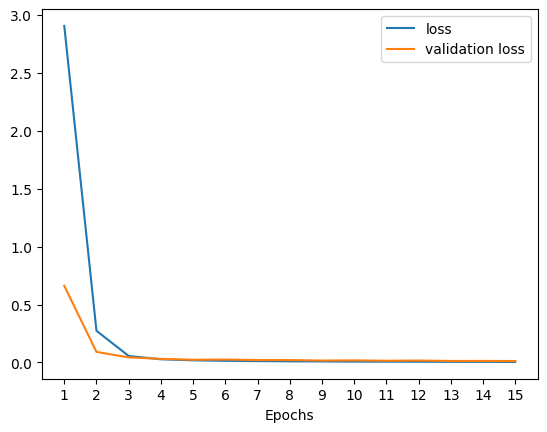

In [ ]:
plot_loss(fit_task1_23, epochs)

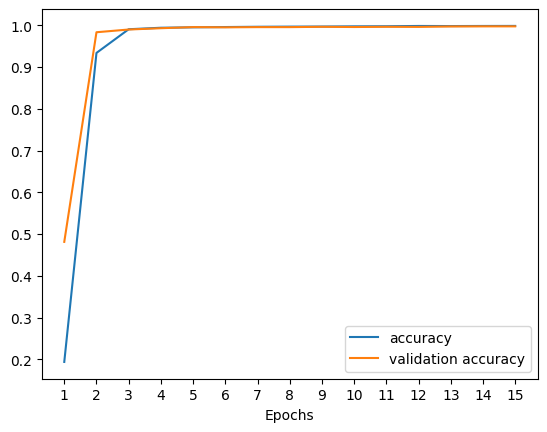

In [ ]:
plot_accuracy(fit_task1_23, epochs)

In [ ]:
model_task1_31 = keras.Sequential(
    [
        keras.Input(shape=(nw,)),
        keras.layers.Dense(15, activation='relu'),
        keras.layers.Dense(1, activation='sigmoid'),
    ]
)

In [ ]:
opt = keras.optimizers.Adam(learning_rate=0.005)
model_task1_31.compile(loss='binary_crossentropy',
               optimizer=opt,
               metrics=['accuracy'])

In [ ]:
# fit the model
batch_size=20
epochs=15
fit_task1_31 = model_task1_31.fit(data,labels,
                  batch_size=batch_size,
                  epochs=epochs,
                  class_weight=class_weights,
                  validation_split=0.3)

Epoch 1/15
447/447 [==============================] - 3s 5ms/step - loss: 0.6229 - accuracy: 0.9329 - val_loss: 0.0444 - val_accuracy: 0.9883
Epoch 2/15
447/447 [==============================] - 1s 3ms/step - loss: 0.0216 - accuracy: 0.9935 - val_loss: 0.0251 - val_accuracy: 0.9943
Epoch 3/15
447/447 [==============================] - 1s 3ms/step - loss: 0.0119 - accuracy: 0.9961 - val_loss: 0.0243 - val_accuracy: 0.9943
Epoch 4/15
447/447 [==============================] - 1s 3ms/step - loss: 0.0085 - accuracy: 0.9968 - val_loss: 0.0183 - val_accuracy: 0.9963
Epoch 5/15
447/447 [==============================] - 1s 3ms/step - loss: 0.0064 - accuracy: 0.9980 - val_loss: 0.0150 - val_accuracy: 0.9969
Epoch 6/15
447/447 [==============================] - 1s 3ms/step - loss: 0.0047 - accuracy: 0.9984 - val_loss: 0.0192 - val_accuracy: 0.9963
Epoch 7/15
447/447 [==============================] - 1s 3ms/step - loss: 0.0039 - accuracy: 0.9988 - val_loss: 0.0157 - val_accuracy: 0.9971
Epoch 

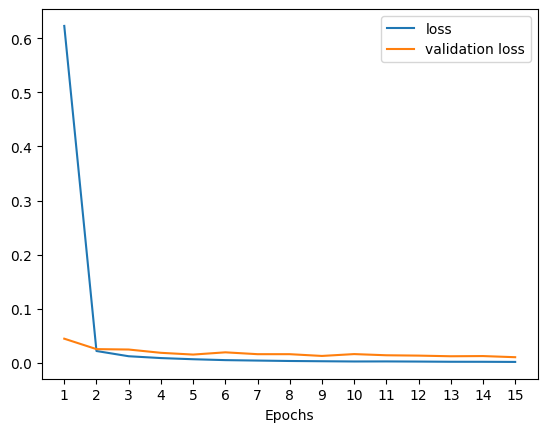

In [ ]:
plot_loss(fit_task1_31,epochs)

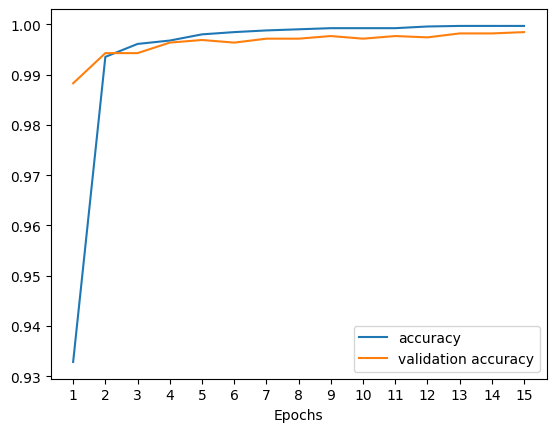

In [ ]:
plot_accuracy(fit_task1_31,epochs)

In [ ]:
loss ={
    "fit loss": fit.history['loss'],
    "fit val_loss": fit.history['val_loss'],
    "fit2 loss": fit2.history['loss'],
    "fit2 val_loss": fit2.history['val_loss'],
    "fit_task1_1 loss": fit_task1_1.history['loss'],
    "fit_task1_1 val_loss": fit_task1_1.history['val_loss'],
    "fit_task1_21 loss": fit_task1_21.history['loss'],
    "fit_task1_21 val_loss": fit_task1_21.history['val_loss'],
    "fit_task1_22 loss": fit_task1_22.history['loss'],
    "fit_task1_22 val_loss": fit_task1_22.history['val_loss'],
    "fit_task1_23 loss": fit_task1_23.history['loss'],
    "fit_task1_23 val_loss": fit_task1_23.history['val_loss'],
    "fit_task1_31 loss": fit_task1_31.history['loss'],
    "fit_task1_31 val_loss": fit_task1_31.history['val_loss'],
}

loss_compare = pd.DataFrame(loss)

In [ ]:
loss_compare


fit loss  fit val_loss  fit2 loss  fit2 val_loss  fit_task1_1 loss  \
0   0.439786      0.159678   0.368340       0.293450          0.368967   
1   0.081211      0.046419   0.109977       0.087084          0.123787   
2   0.028871      0.028100   0.045880       0.043794          0.050318   
3   0.017558      0.021454   0.027872       0.030581          0.024255   
4   0.012980      0.017840   0.021623       0.025862          0.015702   
5   0.010521      0.016650   0.017664       0.021194          0.011918   
6   0.008877      0.015504   0.014815       0.019450          0.010847   
7   0.007807      0.013805   0.012155       0.016105          0.009131   
8   0.006891      0.012285   0.011102       0.014014          0.008465   
9   0.006192      0.013031   0.010393       0.015437          0.008326   
10  0.005670      0.011963   0.008577       0.013787          0.007176   
11  0.005206      0.011601   0.009060       0.013408          0.007824   
12  0.004809      0.010937   0.009118       0.013481          0.008034   
13  0.004451      0.010369   0.009081       0.012560          0.007778   
14  0.004176      0.010604   0.007450       0.012619          0.008130   

    fit_task1_1 val_loss  fit_task1_21 loss  fit_task1_21 val_loss  \
0               0.116980           1.557518               0.470630   
1               0.028334           0.189048               0.116153   
2               0.026802           0.062802               0.059446   
3               0.010829           0.035132               0.041626   
4               0.012775           0.024738               0.032453   
5               0.006445           0.019507               0.029752   
6               0.007360           0.016372               0.026384   
7               0.010233           0.014307               0.024583   
8               0.007720           0.012653               0.020857   
9               0.009003           0.011383               0.021550   
10              0.006828           0.010390               0.019047   
11              0.011291           0.009475               0.019127   
12              0.006200           0.008707               0.017375   
13              0.005725           0.007994               0.016248   
14              0.009593           0.007389               0.016194   

    fit_task1_22 loss  fit_task1_22 val_loss  fit_task1_23 loss  \
0            1.128588               0.954014           2.905023   
1            0.509710               0.764422           0.273099   
2            0.391389               0.640002           0.055718   
3            0.317895               0.533037           0.027124   
4            0.259261               0.439466           0.018206   
5            0.211353               0.360609           0.013843   
6            0.172406               0.297047           0.011541   
7            0.141198               0.244266           0.009588   
8            0.116260               0.200984           0.008388   
9            0.096438               0.169474           0.007212   
10           0.080679               0.143340           0.006731   
11           0.068101               0.120894           0.006027   
12           0.058052               0.103989           0.005389   
13           0.049955               0.089252           0.004991   
14           0.043419               0.077121           0.004447   

    fit_task1_23 val_loss  fit_task1_31 loss  fit_task1_31 val_loss  
0                0.661467           0.622929               0.044398  
1                0.090910           0.021610               0.025093  
2                0.043861           0.011924               0.024348  
3                0.030866           0.008549               0.018264  
4                0.023156           0.006383               0.015017  
5                0.024920           0.004740               0.019162  
6                0.020520           0.003920               0.015749  
7                0.020629           0.003145               0.0157

In [ ]:
min_loss = loss_compare['fit_task1_31 val_loss'].min()

In [ ]:
print(f'Change Adam learning rate help reduce loss to {min_loss}')

Change Adam learning rate help reduce loss to 0.010148380883038044


## <span style="color:red">Task 2</span>

Another way to improve the results is to change the formulation of the problem. For example, instead of classifying all wavelets into only two classes (seafloor and non-seafloor), we can increase the number of classes and try, for example, three classes: water, seafloor, and sediments below the seafloor.

In [ ]:
section = seismic[500, :, :]
seafloor = z[500, :]

w_wavelets = []
s_wavelets = []

cases = 40

for k in range(ntraces):
    trace = section[k, :]
    # convert miliseconds to index
    sf = int(np.rint(seafloor[k]/(dt*1000)))
    for case in range(cases):
        # select center randomly
        center = random.randint(nw, nt-nw)
        # make sure it is not at the seafloor
        while center == sf:
            center = random.randint(nw, nt-nw)
        # extract wavelet
        wavelet = trace[center-nw//2:center+nw//2+1]
        if center < sf:
            w_wavelets.append(wavelet)
        else:
            s_wavelets.append(wavelet)

In [ ]:
len(sf_wavelets)

1161

In [ ]:
len(s_wavelets)

39240

In [ ]:
len(w_wavelets)

7200

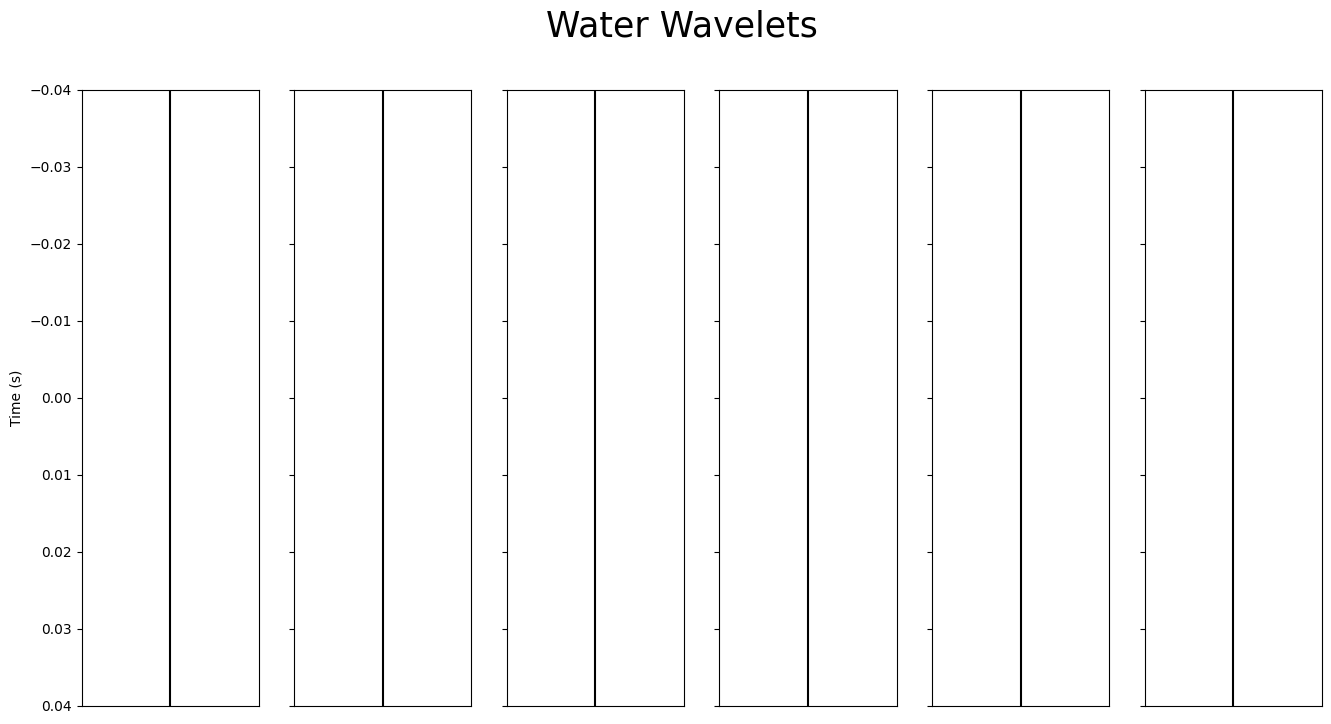

In [ ]:
plot_wavelets(w_wavelets, np.arange(100, 601, 100), 'Water Wavelets')

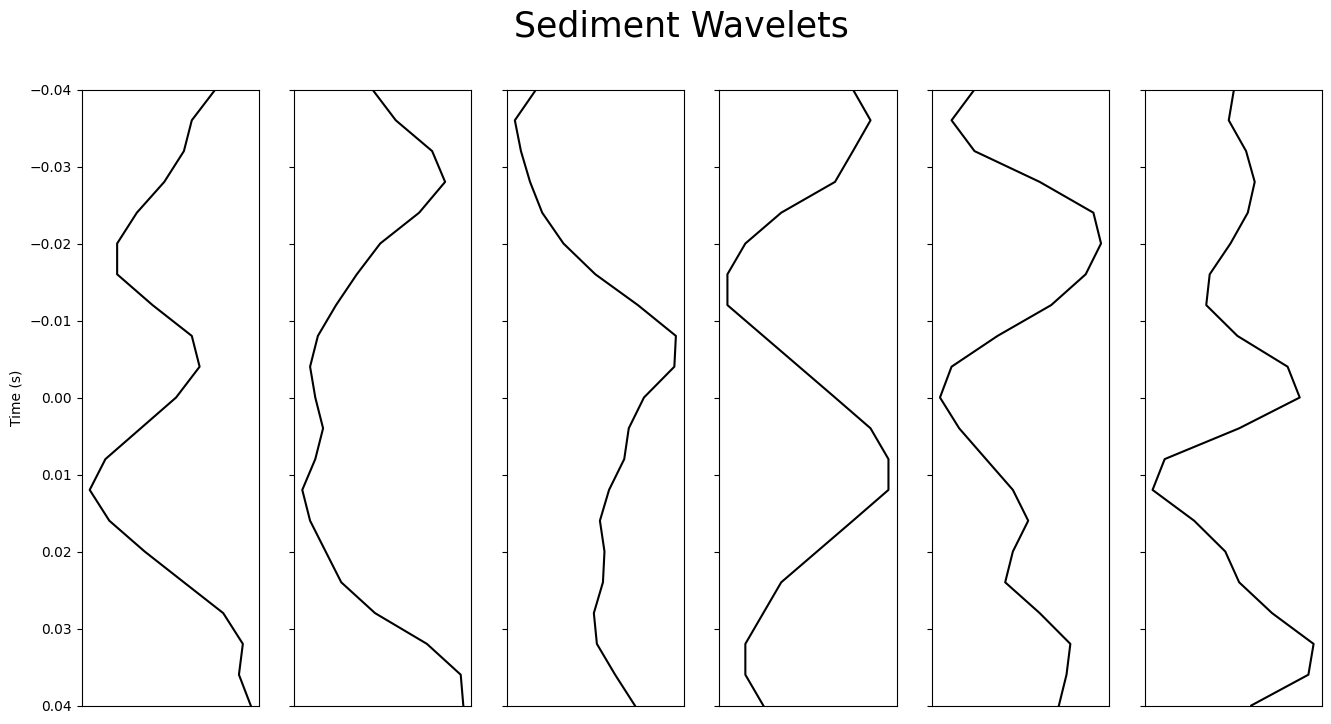

In [ ]:
plot_wavelets(s_wavelets, np.arange(100, 601, 100), 'Sediment Wavelets')

In [ ]:
random.seed(2024)

all_wavelets = w_wavelets + sf_wavelets + s_wavelets
random.shuffle(all_wavelets)
data3 = np.array(all_wavelets)
data3 = data3 * scale
data3.shape  #21 = wave length that we set for cut specific wave

(47601, 21)

In [ ]:
random.seed(2024)

indicators3 = [0]*len(w_wavelets) + [1]*len(sf_wavelets) + [2]*len(s_wavelets)
random.shuffle(indicators3)
labels3 = np.array(indicators3)
labels3.shape

(47601,)

To classify data into multiple classes, we can represent our labels as arrays with three elements corresponding to the probabilities of the three possible outcomes.

In [ ]:
labels3 = keras.utils.to_categorical(labels3)
labels3.shape

(47601, 3)

In the model definition, we must change the size of the output layer and the output activation function.

In [ ]:
model3 = keras.Sequential(
    [
        keras.Input(shape=(nw,)),
        keras.layers.Dense(8, activation='relu'),
        keras.layers.Dense(3, activation='softmax'),
    ]
)

In [ ]:
model3.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 8)                 176       
                                                                 
 dense_16 (Dense)            (None, 3)                 27        
                                                                 
Total params: 203 (812.00 Byte)
Trainable params: 203 (812.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


The model is now
$$\mathbf{y} = s_3\left(\mathbf{a}_2 + \mathbf{B}_2^{T}\,r\left(\mathbf{a}_1 + \mathbf{B}_1^{T}\,\mathbf{x}\right)\right)\;,$$

where $\mathbf{a}_2$ is a three-dimensional vector, $\mathbf{B}_2$ is an $8 \times 3$ matrix, and $s_3(z)$ is the *softmax* function:
$$s_3(\mathbf{z}) = \displaystyle \frac{1}{e^{z_1}+e^{z_2}+e^{z_3}}\,\left[\begin{array}{c} e^{z_1} \\ e^{z_2} \\ e^{z^3} \end{array}\right]\;.$$

Softmax is a multidimensional analog of sigmoid. It guarantees that all elements of the output vector are in the range from 0 to 1 and sum up to 1, thus approximating probabilities.

In [ ]:
(8*21+8)+(3*8+3)

203

In [ ]:
model3.compile(loss='categorical_crossentropy',
               optimizer=keras.optimizers.Adam(0.001),
               metrics=['accuracy'])

<span style="color:red">Complete model training and testing.</span>

In [ ]:
# Apply weighting
class_weights3 = compute_class_weight('balanced', classes=[0,1,2], y=indicators3)
class_weights3 = dict(enumerate(class_weights3))
print(class_weights3)

{0: 2.20375, 1: 13.666666666666666, 2: 0.4043577981651376}


In [ ]:
# fit the model
batch_size=20
epochs=15  #No. of iteration
fit3 = model3.fit(data3,labels3,
                batch_size=batch_size,
                epochs=epochs,
                class_weight=class_weights3,
                validation_split=0.3) #split data for training and testing

Epoch 1/15
1666/1666 [==============================] - 7s 4ms/step - loss: 0.5133 - accuracy: 0.7997 - val_loss: 0.4067 - val_accuracy: 0.7949
Epoch 2/15
1666/1666 [==============================] - 4s 3ms/step - loss: 0.2124 - accuracy: 0.8443 - val_loss: 0.2447 - val_accuracy: 0.8810
Epoch 3/15
1666/1666 [==============================] - 4s 3ms/step - loss: 0.1368 - accuracy: 0.8986 - val_loss: 0.1875 - val_accuracy: 0.9104
Epoch 4/15
1666/1666 [==============================] - 5s 3ms/step - loss: 0.1013 - accuracy: 0.9244 - val_loss: 0.1520 - val_accuracy: 0.9286
Epoch 5/15
1666/1666 [==============================] - 5s 3ms/step - loss: 0.0819 - accuracy: 0.9396 - val_loss: 0.1270 - val_accuracy: 0.9427
Epoch 6/15
1666/1666 [==============================] - 5s 3ms/step - loss: 0.0703 - accuracy: 0.9494 - val_loss: 0.1177 - val_accuracy: 0.9490
Epoch 7/15
1666/1666 [==============================] - 5s 3ms/step - loss: 0.0624 - accuracy: 0.9556 - val_loss: 0.1114 - val_accuracy:

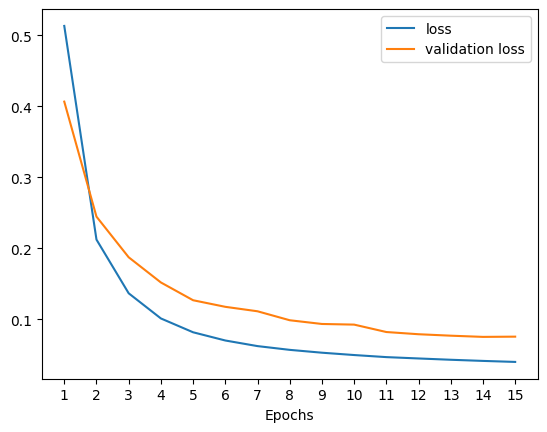

In [ ]:
plot_loss(fit3, epochs)

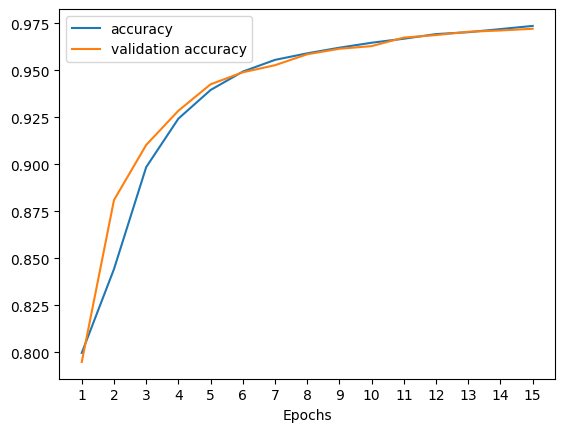

In [ ]:
plot_accuracy(fit3, epochs)

In [ ]:
loss_compare['fit3 loss'] = fit3.history['loss']
loss_compare['fit3 val_loss'] = fit3.history['val_loss']
loss_compare

fit loss  fit val_loss  fit2 loss  fit2 val_loss  fit_task1_1 loss  \
0   0.439786      0.159678   0.368340       0.293450          0.368967   
1   0.081211      0.046419   0.109977       0.087084          0.123787   
2   0.028871      0.028100   0.045880       0.043794          0.050318   
3   0.017558      0.021454   0.027872       0.030581          0.024255   
4   0.012980      0.017840   0.021623       0.025862          0.015702   
5   0.010521      0.016650   0.017664       0.021194          0.011918   
6   0.008877      0.015504   0.014815       0.019450          0.010847   
7   0.007807      0.013805   0.012155       0.016105          0.009131   
8   0.006891      0.012285   0.011102       0.014014          0.008465   
9   0.006192      0.013031   0.010393       0.015437          0.008326   
10  0.005670      0.011963   0.008577       0.013787          0.007176   
11  0.005206      0.011601   0.009060       0.013408          0.007824   
12  0.004809      0.010937   0.009118       0.013481          0.008034   
13  0.004451      0.010369   0.009081       0.012560          0.007778   
14  0.004176      0.010604   0.007450       0.012619          0.008130   

    fit_task1_1 val_loss  fit_task1_21 loss  fit_task1_21 val_loss  \
0               0.116980           1.557518               0.470630   
1               0.028334           0.189048               0.116153   
2               0.026802           0.062802               0.059446   
3               0.010829           0.035132               0.041626   
4               0.012775           0.024738               0.032453   
5               0.006445           0.019507               0.029752   
6               0.007360           0.016372               0.026384   
7               0.010233           0.014307               0.024583   
8               0.007720           0.012653               0.020857   
9               0.009003           0.011383               0.021550   
10              0.006828           0.010390               0.019047   
11              0.011291           0.009475               0.019127   
12              0.006200           0.008707               0.017375   
13              0.005725           0.007994               0.016248   
14              0.009593           0.007389               0.016194   

    fit_task1_22 loss  fit_task1_22 val_loss  fit_task1_23 loss  \
0            1.128588               0.954014           2.905023   
1            0.509710               0.764422           0.273099   
2            0.391389               0.640002           0.055718   
3            0.317895               0.533037           0.027124   
4            0.259261               0.439466           0.018206   
5            0.211353               0.360609           0.013843   
6            0.172406               0.297047           0.011541   
7            0.141198               0.244266           0.009588   
8            0.116260               0.200984           0.008388   
9            0.096438               0.169474           0.007212   
10           0.080679               0.143340           0.006731   
11           0.068101               0.120894           0.006027   
12           0.058052               0.103989           0.005389   
13           0.049955               0.089252           0.004991   
14           0.043419               0.077121           0.004447   

    fit_task1_23 val_loss  fit_task1_31 loss  fit_task1_31 val_loss  \
0                0.661467           0.622929               0.044398   
1                0.090910           0.021610               0.025093   
2                0.043861           0.011924               0.024348   
3                0.030866           0.008549               0.018264   
4                0.023156           0.006383               0.015017   
5                0.024920           0.004740               0.019162   
6                0.020520           0.003920               0.015749   
7                0.020629           0.003145             

In [ ]:
accuracy ={
    "fit accuracy": fit.history['accuracy'],
    "fit val_accuracy": fit.history['val_accuracy'],
    "fit2 accuracy": fit2.history['accuracy'],
    "fit2 val_accuracy": fit2.history['val_accuracy'],
    "fit_task1_1 accuracy": fit_task1_1.history['accuracy'],
    "fit_task1_1 val_accuracy": fit_task1_1.history['val_accuracy'],
    "fit_task1_21 accuracy": fit_task1_21.history['accuracy'],
    "fit_task1_21 val_accuracy": fit_task1_21.history['val_accuracy'],
    "fit_task1_22 accuracy": fit_task1_22.history['accuracy'],
    "fit_task1_22 val_accuracy": fit_task1_22.history['val_accuracy'],
    "fit_task1_23 accuracy": fit_task1_23.history['accuracy'],
    "fit_task1_23 val_accuracy": fit_task1_23.history['val_accuracy'],
    "fit_task1_31 accuracy": fit_task1_31.history['accuracy'],
    "fit_task1_31 val_accuracy": fit_task1_31.history['val_accuracy'],
    "fit3 accuracy": fit3.history['accuracy'],
    "fit3 val_accuracy": fit3.history['val_accuracy'],
}

accuracy_compare = pd.DataFrame(accuracy)
accuracy_compare

fit accuracy  fit val_accuracy  fit2 accuracy  fit2 val_accuracy  \
0       0.945632          0.989562       0.818995           0.971816   
1       0.993959          0.993476       0.985009           0.990084   
2       0.995190          0.993476       0.992169           0.991649   
3       0.995637          0.993998       0.993512           0.993215   
4       0.995973          0.995042       0.994295           0.992954   
5       0.996532          0.995564       0.995190           0.993998   
6       0.996980          0.995825       0.994630           0.994520   
7       0.996756          0.996347       0.995861           0.996086   
8       0.997315          0.997129       0.995973           0.996868   
9       0.997651          0.996868       0.996196           0.996608   
10      0.997763          0.997129       0.997091           0.996868   
11      0.997986          0.997129       0.996756           0.997129   
12      0.997874          0.997390       0.996756           0.997390   
13      0.998210          0.997390       0.996756           0.997651   
14      0.998322          0.997390       0.997427           0.997651   

    fit_task1_1 accuracy  fit_task1_1 val_accuracy  fit_task1_21 accuracy  \
0               0.997905                  0.996617               0.436738   
1               0.997149                  0.997015               0.962300   
2               0.996345                  0.994258               0.987247   
3               0.995943                  0.996560               0.990715   
4               0.995967                  0.995850               0.992169   
5               0.996296                  0.997697               0.993400   
6               0.996053                  0.997356               0.994518   
7               0.996443                  0.996504               0.994630   
8               0.996540                  0.997300               0.994966   
9               0.996552                  0.996930               0.995525   
10              0.997052                  0.997754               0.995861   
11              0.996857                  0.996361               0.996085   
12              0.996638                  0.997868               0.996085   
13              0.996564                  0.997925               0.996420   
14              0.996784                  0.996902               0.997091   

    fit_task1_21 val_accuracy  fit_task1_22 accuracy  \
0                    0.894572               0.093187   
1                    0.981733               0.186374   
2                    0.988779               0.720215   
3                    0.990866               0.874818   
4                    0.992693               0.932319   
5                    0.992954               0.957825   
6                    0.993737               0.972480   
7                    0.993737               0.979640   
8                    0.995303               0.984226   
9                    0.995303               0.987247   
10                   0.995825               0.988925   
11                   0.995825               0.989932   
12                   0.996347               0.990603   
13                   0.996086               0.991610   
14                   0.996347               0.992169   

    fit_task1_22 val_accuracy  fit_task1_23 accuracy  \
0                    0.086900               0.193646   
1                    0.555063               0.933773   
2                    0.828549               0.990491   
3                    0.910752               0.994071   
4                    0.944155               0.995078   
5                    0.963205               0.995749   
6                    0.971294               0.996420   
7                    0.979645               0.996756   
8                    0.984342               0.996980   
9                    0.985386               0.997427   
10                   0.987213               0.997651   
11                   0.988518               0.998

In [ ]:
# predicting probabilities
pred3 = model3.predict(data3)
#print(pred)

1488/1488 [==============================] - 3s 2ms/step


In [ ]:
np.shape(pred3)

(47601, 3)

In [ ]:
#find examples of mis-identified wavelets.
false3 = np.nonzero(np.rint(pred3) != labels3)
print(false3)

(array([   11,    11,    40, ..., 47506, 47587, 47587]), array([0, 2, 0, ..., 2, 0, 2]))


In [ ]:
from scipy.signal import find_peaks

section = seismic[400, :, :1001]

pick = np.zeros(ntraces)
for k in range(ntraces):
    trace = section[k, :]
    # find local maxima
    peaks, _ = find_peaks(np.abs(trace))
    test_wavelets = []
    for peak in peaks:
        if peak > nw and peak < 1001-nw:
            wavelet = trace[peak-nw//2:peak+nw//2+1]
            test_wavelets.append(wavelet)
    # normalize
    test_wavelets = np.array(test_wavelets)*scale
    # get probabilities
    pred3 = model3.predict(test_wavelets)
    # select the highest probability
    best = np.argmax(pred)
    pick[k] = peaks[best]

7/7 [==============================] - 0s 3ms/step


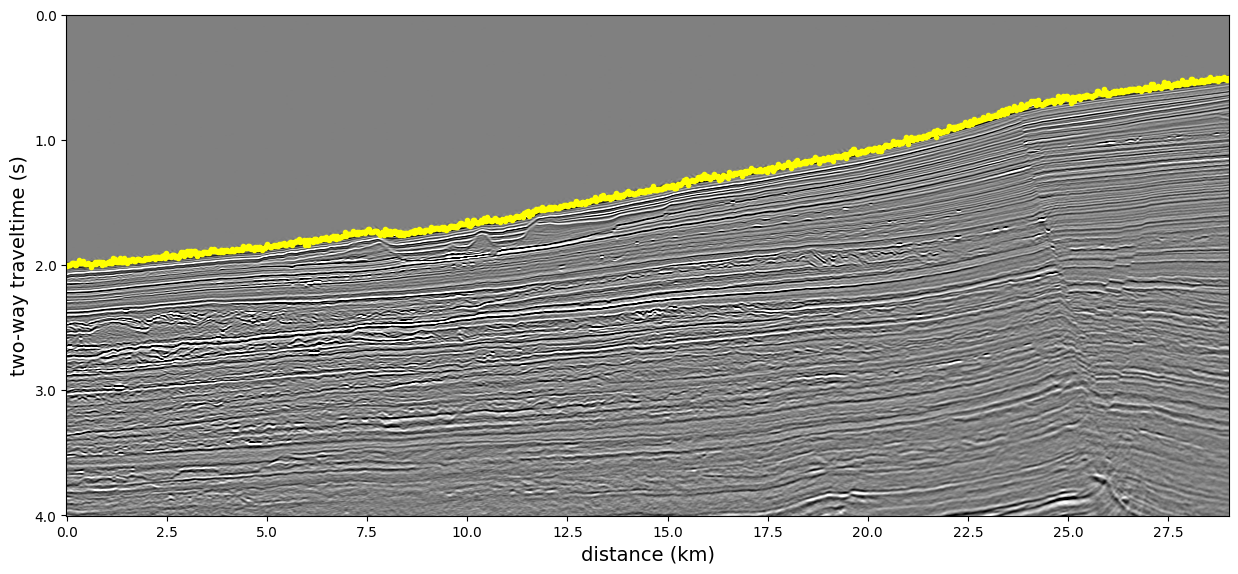

In [ ]:
plt.figure(figsize=(15, 10))
plot_seismic(section)
plt.plot(pick, color='yellow', marker='.', linestyle='None')
plt.show()

## <span style="color:red">Bonus Task</span>

You can repeat the experiment with your modifications using PyTorch for an extra-credit bonus task.

In [ ]:
import torch
import torch.nn as nn

drop = 0.1

# define neural net
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.seq = nn.Sequential(
                                nn.Linear(21,8),
                                nn.ReLU(),
                                nn.Dropout(p=drop),
                                nn.Linear(8,1),
                                nn.Sigmoid(),
                                )
    def forward(self, x):
        return (self.seq(x))

net = Net()

In [ ]:
from torchsummary import summary

summary(net, data.shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1             [-1, 12771, 8]             176
              ReLU-2             [-1, 12771, 8]               0
           Dropout-3             [-1, 12771, 8]               0
            Linear-4             [-1, 12771, 1]               9
           Sigmoid-5             [-1, 12771, 1]               0
Total params: 185
Trainable params: 185
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 1.02
Forward/backward pass size (MB): 2.53
Params size (MB): 0.00
Estimated Total Size (MB): 3.56
----------------------------------------------------------------


In [ ]:
torch.manual_seed(2024) # for reproducibility

In [ ]:
from sklearn.model_selection import train_test_split
from torch.utils.data import  TensorDataset

data_t = torch.tensor(data, dtype=torch.float32, requires_grad=True)
labels_t = torch.tensor(labels, dtype=torch.float32)

x_train, x_test, y_train, y_test = train_test_split(data_t, labels_t,
                                                    test_size=0.3,
                                                    random_state=2024)

set_train = TensorDataset(x_train, y_train)
set_test = TensorDataset(x_test, y_test)

In [ ]:
from torch.utils.data import WeightedRandomSampler

w_train = [class_weights[label.item()] for label in y_train]
w_test  = [class_weights[label.item()] for label in y_test]
sample_train = WeightedRandomSampler(w_train, len(w_train), replacement=True)
sample_test  = WeightedRandomSampler(w_test,  len(w_test),  replacement=True)

In [ ]:
from torch.utils.data import DataLoader

batch_size=20

load_train = DataLoader(set_train, batch_size=batch_size, shuffle=False, sampler=sample_train)
load_test  = DataLoader(set_test,  batch_size=batch_size, shuffle=False, sampler=sample_test)

In [ ]:
loss_function = nn.BCELoss() # binary cross-entropy
optimizer = torch.optim.Adam(net.parameters())

In [ ]:
#for k, v in enumerate(load_train):
#  print(f"Index: {k}, Data0: {v[0]}, Data1: {v[1]}, length: {len(v)}")

In [ ]:
#v[0].size(0)

NameError: name 'v' is not defined

In [ ]:
#v[1]

In [ ]:
train_history = {'Train_loss': [],
                 'Train_accuracy': [],
                 'Test_loss': [],
                 'Test_accuracy': []}

epochs=15

# Train the model
for epoch in range(epochs):
    train_loss = 0.0
    train_correct = 0
    # set the model to training mode
    net.train(True)

    for k, v in enumerate(load_train):
        # reset gradients
        optimizer.zero_grad()
        # forward pass
        output = net(v[0])
        # calculate loss
        loss = loss_function(output.flatten(), v[1])
        # back propagation
        loss.backward(retain_graph=True)
        # update weights
        optimizer.step()

        train_loss += loss.item() * v[0].size(0)
        pred = torch.round(output.flatten())
        train_correct += (pred == v[1]).sum().item()

    train_loss /= len(load_train.dataset)
    train_acc = train_correct / len(load_train.dataset)
    train_history['Train_loss'].append(train_loss)
    train_history['Train_accuracy'].append(train_acc)

    test_loss = 0.0
    test_correct = 0
    # set the model to evaluation mode
    net.eval()

    with torch.no_grad():
        for k, v in enumerate(load_test):
            output = net(v[0])
            loss = loss_function(output, torch.unsqueeze(v[1], 1))

            test_loss += loss.item() * v[0].size(0)
            pred = torch.round(output.flatten())
            test_correct += (pred == v[1]).sum().item()

    test_loss /= len(load_test.dataset)
    test_acc = test_correct / len(load_test.dataset)
    train_history['Test_loss'].append(test_loss)
    train_history['Test_accuracy'].append(test_acc)

    print(f'Epoch {epoch+1}: '
          f'Train Loss: {train_loss:.4f}, Train Accuracy: {100*train_acc:.2f}%, '
          f'Test Loss: {test_loss:.4f}, Test Accuracy: {100*test_acc:.2f}%')

Epoch 1: Train Loss: 0.3669, Train Accuracy: 91.63%, Test Loss: 0.1747, Test Accuracy: 92.59%
Epoch 2: Train Loss: 0.1146, Train Accuracy: 98.57%, Test Loss: 0.0412, Test Accuracy: 99.77%
Epoch 3: Train Loss: 0.0603, Train Accuracy: 99.79%, Test Loss: 0.0180, Test Accuracy: 99.87%
Epoch 4: Train Loss: 0.0467, Train Accuracy: 99.81%, Test Loss: 0.0093, Test Accuracy: 99.95%
Epoch 5: Train Loss: 0.0383, Train Accuracy: 99.87%, Test Loss: 0.0059, Test Accuracy: 99.97%
Epoch 6: Train Loss: 0.0317, Train Accuracy: 99.93%, Test Loss: 0.0064, Test Accuracy: 99.87%
Epoch 7: Train Loss: 0.0271, Train Accuracy: 99.88%, Test Loss: 0.0039, Test Accuracy: 99.97%
Epoch 8: Train Loss: 0.0218, Train Accuracy: 99.94%, Test Loss: 0.0026, Test Accuracy: 99.97%
Epoch 9: Train Loss: 0.0201, Train Accuracy: 99.87%, Test Loss: 0.0019, Test Accuracy: 100.00%
Epoch 10: Train Loss: 0.0167, Train Accuracy: 99.93%, Test Loss: 0.0023, Test Accuracy: 99.97%
Epoch 11: Train Loss: 0.0139, Train Accuracy: 99.93%, Test

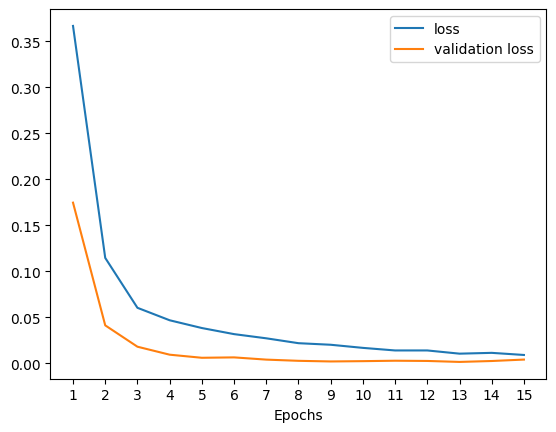

In [ ]:
def plot_loss(history, epochs):
    iterations = np.arange(1, epochs+1)
    plt.plot(iterations, history['Train_loss'], label='loss')
    plt.plot(iterations, history['Test_loss'], label='validation loss')
    plt.legend()
    #plt.ylim(0.0, 0.2)
    plt.xticks(iterations[::epochs//10])
    plt.xlabel('Epochs')
    plt.show()


plot_loss(train_history, epochs)

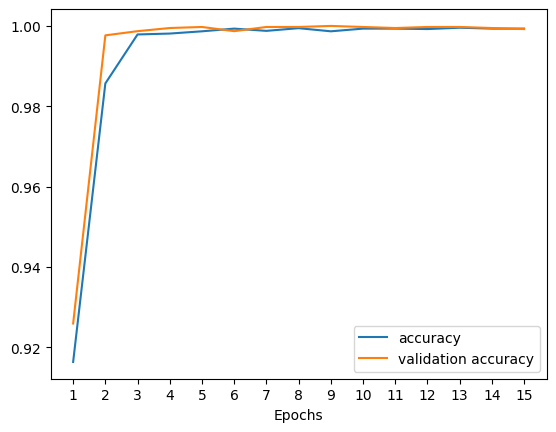

In [ ]:
def plot_accuracy(history, epochs):
    iterations = np.arange(1, epochs+1)
    plt.plot(iterations, history['Train_accuracy'], label='accuracy')
    plt.plot(iterations, history['Test_accuracy'], label='validation accuracy')
    plt.legend()
    #plt.ylim(0.9, 1.0)
    plt.xticks(iterations[::epochs//10])
    plt.xlabel('Epochs')
    plt.show()


plot_accuracy(train_history, epochs)

In [ ]:
# applying model to make predictions

pred_t = net(data_t)
pred = pred_t.detach().numpy()

In [ ]:
# misidentified wavelets

false = (np.nonzero(np.rint(pred[:,0]) != labels))
print(false)

(array([  262,   340,   420,   737,   767,  1202,  1210,  1325,  1412,
        1494,  1725,  2030,  2096,  2100,  2115,  2237,  2577,  3027,
        3369,  3372,  3495,  3701,  3820,  4221,  4449,  4512,  4618,
        4708,  4859,  4956,  5047,  5289,  5587,  5730,  5881,  6589,
        7135,  7154,  7332,  7345,  7373,  7599,  7606,  7626,  7777,
        7887,  7997,  8501,  8573,  8605,  8626,  8732,  8976,  9147,
        9270,  9315,  9653,  9824,  9830,  9943, 10188, 10275, 10408,
       10442, 10625, 10953, 11024, 11055, 11401, 11603, 11651, 11919,
       12044, 12443]),)


net_Btask_1: increase output layer size from 8 to 15

net_Btask_2: add more layer to nueral network (n1=8, n2=4)

net_Btask_3: change adam learning rate from 0.001 (default) to 0.005

net_Btask_4: split data to water, seafloor, sediment wavelets

Use original data (case = 10) instead of case 100

In [ ]:
# define neural net of net_Btask_1 - increase output layer size from 8 to 15
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.seq = nn.Sequential(
                                nn.Linear(21,15),
                                nn.ReLU(),
                                nn.Dropout(p=drop), #first try cut dropout but result quite fluctuate. Thus, add drop out again
                                nn.Linear(15,1),
                                nn.Sigmoid(),
                                )
    def forward(self, x):
        return (self.seq(x))

net_Btask_1 = Net()

In [ ]:
from torchsummary import summary

summary(net_Btask_1, data.shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1            [-1, 12771, 15]             330
              ReLU-2            [-1, 12771, 15]               0
           Dropout-3            [-1, 12771, 15]               0
            Linear-4             [-1, 12771, 1]              16
           Sigmoid-5             [-1, 12771, 1]               0
Total params: 346
Trainable params: 346
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 1.02
Forward/backward pass size (MB): 4.58
Params size (MB): 0.00
Estimated Total Size (MB): 5.60
----------------------------------------------------------------


In [ ]:
#Data is same, only model is change from net to net_Btask_1

loss_function = nn.BCELoss() # binary cross-entropy
optimizer = torch.optim.Adam(net_Btask_1.parameters())

In [ ]:
train_history1 = {'Train_loss': [],
                 'Train_accuracy': [],
                 'Test_loss': [],
                 'Test_accuracy': []}

epochs=15

for epoch in range(epochs):
    train_loss = 0.0
    train_correct = 0
    # set the model to training mode
    net_Btask_1.train(True)

    for k, v in enumerate(load_train):
        # reset gradients
        optimizer.zero_grad()
        # forward pass
        output = net_Btask_1(v[0])
        # calculate loss
        loss = loss_function(output.flatten(), v[1])
        # back propagation
        loss.backward(retain_graph=True)
        # update weights
        optimizer.step()

        train_loss += loss.item() * v[0].size(0)
        pred = torch.round(output.flatten())
        train_correct += (pred == v[1]).sum().item()

    train_loss /= len(load_train.dataset)
    train_acc = train_correct / len(load_train.dataset)
    train_history1['Train_loss'].append(train_loss)
    train_history1['Train_accuracy'].append(train_acc)

    test_loss = 0.0
    test_correct = 0
    # set the model to evaluation mode
    net_Btask_1.eval()

    with torch.no_grad():
        for k, v in enumerate(load_test):
            output = net_Btask_1(v[0])
            loss = loss_function(output, torch.unsqueeze(v[1], 1))

            test_loss += loss.item() * v[0].size(0)
            pred = torch.round(output.flatten())
            test_correct += (pred == v[1]).sum().item()

    test_loss /= len(load_test.dataset)
    test_acc = test_correct / len(load_test.dataset)
    train_history1['Test_loss'].append(test_loss)
    train_history1['Test_accuracy'].append(test_acc)

    print(f'Epoch {epoch+1}: '
          f'Train Loss: {train_loss:.4f}, Train Accuracy: {100*train_acc:.2f}%, '
          f'Test Loss: {test_loss:.4f}, Test Accuracy: {100*test_acc:.2f}%')

Epoch 1: Train Loss: 0.1953, Train Accuracy: 93.27%, Test Loss: 0.0716, Test Accuracy: 98.15%
Epoch 2: Train Loss: 0.0368, Train Accuracy: 99.40%, Test Loss: 0.0137, Test Accuracy: 99.82%
Epoch 3: Train Loss: 0.0123, Train Accuracy: 99.73%, Test Loss: 0.0071, Test Accuracy: 99.90%
Epoch 4: Train Loss: 0.0071, Train Accuracy: 99.88%, Test Loss: 0.0044, Test Accuracy: 99.95%
Epoch 5: Train Loss: 0.0044, Train Accuracy: 99.92%, Test Loss: 0.0056, Test Accuracy: 99.92%
Epoch 6: Train Loss: 0.0053, Train Accuracy: 99.92%, Test Loss: 0.0027, Test Accuracy: 99.97%
Epoch 7: Train Loss: 0.0035, Train Accuracy: 99.94%, Test Loss: 0.0054, Test Accuracy: 99.87%
Epoch 8: Train Loss: 0.0054, Train Accuracy: 99.91%, Test Loss: 0.0037, Test Accuracy: 99.87%
Epoch 9: Train Loss: 0.0026, Train Accuracy: 99.94%, Test Loss: 0.0030, Test Accuracy: 99.92%
Epoch 10: Train Loss: 0.0054, Train Accuracy: 99.89%, Test Loss: 0.0040, Test Accuracy: 99.90%
Epoch 11: Train Loss: 0.0040, Train Accuracy: 99.91%, Test 

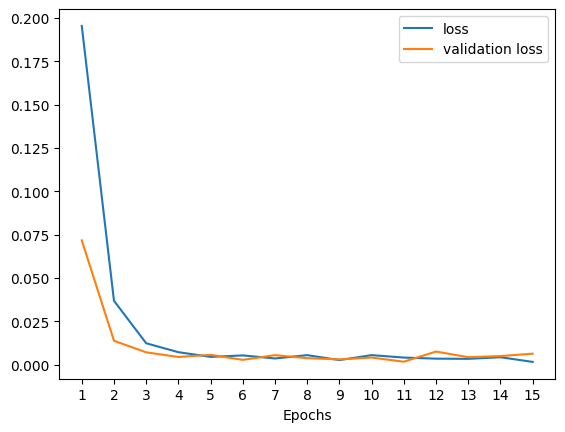

In [ ]:
plot_loss(train_history1, epochs)

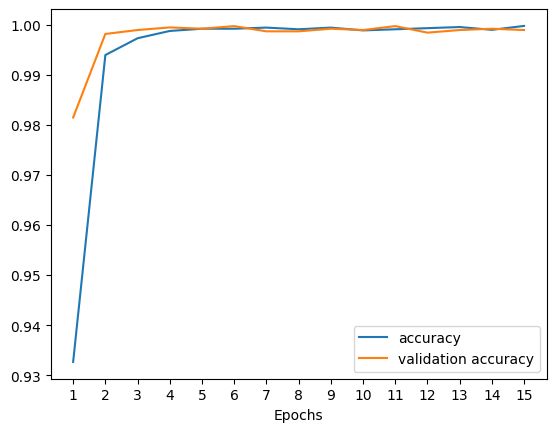

In [ ]:
plot_accuracy(train_history1, epochs)

In [ ]:
# define neural net of net_Btask_2 - add more layer to nueral network (n1=8, n2=4)
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.seq = nn.Sequential(
                                nn.Linear(21,8),
                                nn.ReLU(),
                                #nn.Dropout(p=drop),
                                nn.Linear(8,4),
                                nn.ReLU(),
                                #nn.Dropout(p=drop),
                                nn.Linear(4,1),
                                nn.Sigmoid(),
                                )
    def forward(self, x):
        return (self.seq(x))

net_Btask_2 = Net()
summary(net_Btask_2, data.shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1             [-1, 12771, 8]             176
              ReLU-2             [-1, 12771, 8]               0
            Linear-3             [-1, 12771, 4]              36
              ReLU-4             [-1, 12771, 4]               0
            Linear-5             [-1, 12771, 1]               5
           Sigmoid-6             [-1, 12771, 1]               0
Total params: 217
Trainable params: 217
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 1.02
Forward/backward pass size (MB): 2.53
Params size (MB): 0.00
Estimated Total Size (MB): 3.56
----------------------------------------------------------------


In [ ]:
#Data is same, only model is change from net to net_Btask_2

loss_function = nn.BCELoss() # binary cross-entropy
optimizer = torch.optim.Adam(net_Btask_2.parameters())

In [ ]:
train_history2 = {'Train_loss': [],
                 'Train_accuracy': [],
                 'Test_loss': [],
                 'Test_accuracy': []}

epochs=15

for epoch in range(epochs):
    train_loss = 0.0
    train_correct = 0
    # set the model to training mode
    net_Btask_2.train(True)

    for k, v in enumerate(load_train):
        # reset gradients
        optimizer.zero_grad()
        # forward pass
        output = net_Btask_2(v[0])
        # calculate loss
        loss = loss_function(output.flatten(), v[1])
        # back propagation
        loss.backward(retain_graph=True)
        # update weights
        optimizer.step()

        train_loss += loss.item() * v[0].size(0)
        pred = torch.round(output.flatten())
        train_correct += (pred == v[1]).sum().item()

    train_loss /= len(load_train.dataset)
    train_acc = train_correct / len(load_train.dataset)
    train_history2['Train_loss'].append(train_loss)
    train_history2['Train_accuracy'].append(train_acc)

    test_loss = 0.0
    test_correct = 0
    # set the model to evaluation mode
    net_Btask_2.eval()

    with torch.no_grad():
        for k, v in enumerate(load_test):
            output = net_Btask_2(v[0])
            loss = loss_function(output, torch.unsqueeze(v[1], 1))

            test_loss += loss.item() * v[0].size(0)
            pred = torch.round(output.flatten())
            test_correct += (pred == v[1]).sum().item()

    test_loss /= len(load_test.dataset)
    test_acc = test_correct / len(load_test.dataset)
    train_history2['Test_loss'].append(test_loss)
    train_history2['Test_accuracy'].append(test_acc)

    print(f'Epoch {epoch+1}: '
          f'Train Loss: {train_loss:.4f}, Train Accuracy: {100*train_acc:.2f}%, '
          f'Test Loss: {test_loss:.4f}, Test Accuracy: {100*test_acc:.2f}%')

Epoch 1: Train Loss: 0.2174, Train Accuracy: 92.18%, Test Loss: 0.0725, Test Accuracy: 97.83%
Epoch 2: Train Loss: 0.0311, Train Accuracy: 99.47%, Test Loss: 0.0127, Test Accuracy: 99.84%
Epoch 3: Train Loss: 0.0076, Train Accuracy: 99.90%, Test Loss: 0.0041, Test Accuracy: 99.95%
Epoch 4: Train Loss: 0.0052, Train Accuracy: 99.89%, Test Loss: 0.0034, Test Accuracy: 99.92%
Epoch 5: Train Loss: 0.0049, Train Accuracy: 99.92%, Test Loss: 0.0047, Test Accuracy: 99.87%
Epoch 6: Train Loss: 0.0037, Train Accuracy: 99.92%, Test Loss: 0.0017, Test Accuracy: 99.97%
Epoch 7: Train Loss: 0.0030, Train Accuracy: 99.93%, Test Loss: 0.0019, Test Accuracy: 99.97%
Epoch 8: Train Loss: 0.0048, Train Accuracy: 99.91%, Test Loss: 0.0017, Test Accuracy: 99.95%
Epoch 9: Train Loss: 0.0023, Train Accuracy: 99.97%, Test Loss: 0.0024, Test Accuracy: 99.95%
Epoch 10: Train Loss: 0.0036, Train Accuracy: 99.93%, Test Loss: 0.0031, Test Accuracy: 99.95%
Epoch 11: Train Loss: 0.0034, Train Accuracy: 99.93%, Test 

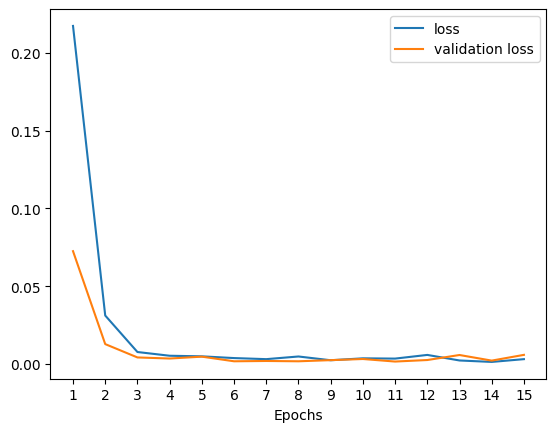

In [ ]:
plot_loss(train_history2, epochs)

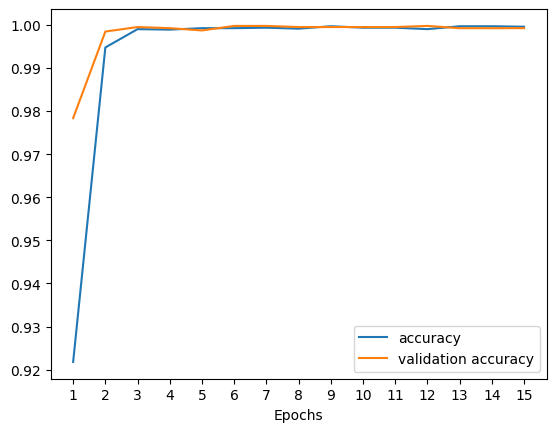

In [ ]:
plot_accuracy(train_history2, epochs)

In [ ]:
# define neural net of net_Btask_3 - change adam learning rate from 0.001 (default) to 0.0001
net_Btask_3 = net

#Data is same, only model is change from net to net_Btask_1

loss_function = nn.BCELoss() # binary cross-entropy
optimizer = torch.optim.Adam(net_Btask_3.parameters(), lr=0.0001)

In [ ]:
train_history3 = {'Train_loss': [],
                 'Train_accuracy': [],
                 'Test_loss': [],
                 'Test_accuracy': []}

epochs=15

for epoch in range(epochs):
    train_loss = 0.0
    train_correct = 0
    # set the model to training mode
    net_Btask_3.train(True)

    for k, v in enumerate(load_train):
        # reset gradients
        optimizer.zero_grad()
        # forward pass
        output = net_Btask_3(v[0])
        # calculate loss
        loss = loss_function(output.flatten(), v[1])
        # back propagation
        loss.backward(retain_graph=True)
        # update weights
        optimizer.step()

        train_loss += loss.item() * v[0].size(0)
        pred = torch.round(output.flatten())
        train_correct += (pred == v[1]).sum().item()

    train_loss /= len(load_train.dataset)
    train_acc = train_correct / len(load_train.dataset)
    train_history3['Train_loss'].append(train_loss)
    train_history3['Train_accuracy'].append(train_acc)

    test_loss = 0.0
    test_correct = 0
    # set the model to evaluation mode
    net_Btask_3.eval()

    with torch.no_grad():
        for k, v in enumerate(load_test):
            output = net_Btask_3(v[0])
            loss = loss_function(output, torch.unsqueeze(v[1], 1))

            test_loss += loss.item() * v[0].size(0)
            pred = torch.round(output.flatten())
            test_correct += (pred == v[1]).sum().item()

    test_loss /= len(load_test.dataset)
    test_acc = test_correct / len(load_test.dataset)
    train_history3['Test_loss'].append(test_loss)
    train_history3['Test_accuracy'].append(test_acc)

    print(f'Epoch {epoch+1}: '
          f'Train Loss: {train_loss:.4f}, Train Accuracy: {100*train_acc:.2f}%, '
          f'Test Loss: {test_loss:.4f}, Test Accuracy: {100*test_acc:.2f}%')

Epoch 1: Train Loss: 0.0071, Train Accuracy: 99.94%, Test Loss: 0.0008, Test Accuracy: 100.00%
Epoch 2: Train Loss: 0.0088, Train Accuracy: 99.90%, Test Loss: 0.0028, Test Accuracy: 99.92%
Epoch 3: Train Loss: 0.0088, Train Accuracy: 99.90%, Test Loss: 0.0016, Test Accuracy: 99.97%
Epoch 4: Train Loss: 0.0069, Train Accuracy: 99.93%, Test Loss: 0.0038, Test Accuracy: 99.92%
Epoch 5: Train Loss: 0.0062, Train Accuracy: 99.96%, Test Loss: 0.0011, Test Accuracy: 99.97%
Epoch 6: Train Loss: 0.0085, Train Accuracy: 99.92%, Test Loss: 0.0040, Test Accuracy: 99.92%
Epoch 7: Train Loss: 0.0079, Train Accuracy: 99.94%, Test Loss: 0.0019, Test Accuracy: 99.92%
Epoch 8: Train Loss: 0.0078, Train Accuracy: 99.92%, Test Loss: 0.0034, Test Accuracy: 99.92%
Epoch 9: Train Loss: 0.0069, Train Accuracy: 99.94%, Test Loss: 0.0019, Test Accuracy: 99.97%
Epoch 10: Train Loss: 0.0058, Train Accuracy: 99.94%, Test Loss: 0.0018, Test Accuracy: 99.95%
Epoch 11: Train Loss: 0.0098, Train Accuracy: 99.89%, Test

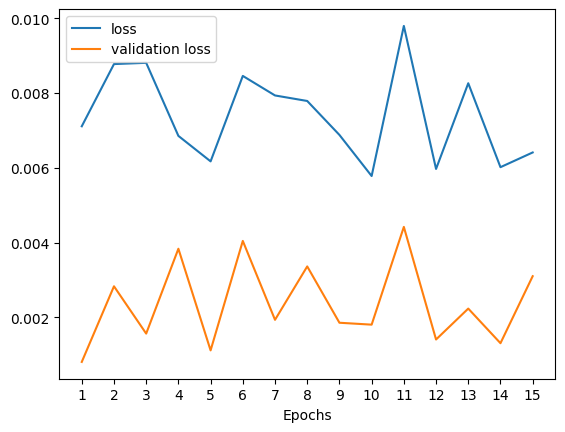

In [ ]:
plot_loss(train_history3, epochs)

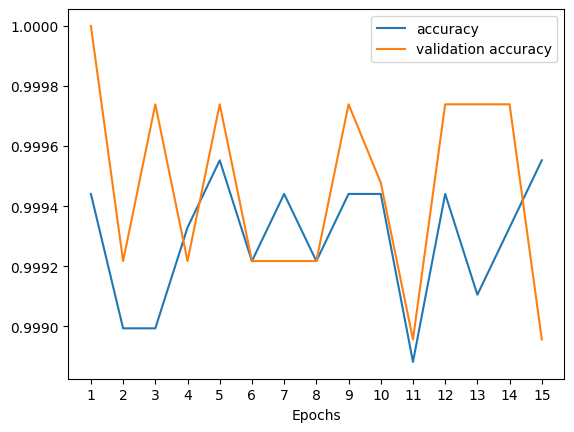

In [ ]:
plot_accuracy(train_history3, epochs)

net_Btask_4: split data to water, seafloor, sediment wavelets

In [ ]:
random.seed(2024)

all_waveletsb = w_wavelets + sf_wavelets + s_wavelets
random.shuffle(all_waveletsb)
datab = np.array(all_waveletsb)
datab = datab * scale
datab.shape  #21 = wave length that we set for cut specific wave

(47601, 21)

In [ ]:
random.seed(2024)

indicatorsb = [0]*len(w_wavelets) + [1]*len(sf_wavelets) + [2]*len(s_wavelets)
random.shuffle(indicatorsb)
labelsb = np.array(indicatorsb)
labelsb.shape

(47601,)

In [ ]:
labelsb

array([2, 0, 2, ..., 2, 2, 2])

In [ ]:
import torch
from torch.nn.functional import one_hot

# Convert the labels4 array to a PyTorch tensor
labelsb_tensor = torch.tensor(labelsb)

# Use the one_hot function to convert the labels to one-hot encoding
labelsb_onehot = one_hot(labelsb_tensor, num_classes=3)

# Print the shape of the resulting tensor
print(labelsb_onehot.shape)

torch.Size([47601, 3])


In [ ]:
labelsb_onehot

tensor([[0, 0, 1],
        [1, 0, 0],
        [0, 0, 1],
        ...,
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1]])

In [ ]:
# net_Btask_4: split data to water, seafloor, sediment wavelets
drop = 0.1

# define neural net
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.seq = nn.Sequential(
                                nn.Linear(21,8),
                                nn.ReLU(),
                                nn.Dropout(p=drop),
                                nn.Linear(8,3),
                                nn.Sigmoid(),
                                )
    def forward(self, x):
        return (self.seq(x))

net_Btask_4 = Net()
summary(net_Btask_4, datab.shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1             [-1, 47601, 8]             176
              ReLU-2             [-1, 47601, 8]               0
           Dropout-3             [-1, 47601, 8]               0
            Linear-4             [-1, 47601, 3]              27
           Sigmoid-5             [-1, 47601, 3]               0
Total params: 203
Trainable params: 203
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 3.81
Forward/backward pass size (MB): 10.90
Params size (MB): 0.00
Estimated Total Size (MB): 14.71
----------------------------------------------------------------


In [ ]:
# Train-Test Data set
from sklearn.model_selection import train_test_split
from torch.utils.data import  TensorDataset

#update data to be sf-wavelets, sw-wavelets, wavelets

data_t4 = torch.tensor(datab, dtype=torch.float32, requires_grad=True)
labels_t4 = torch.tensor(np.array(labelsb), dtype=torch.float32)

x_train, x_test, y_train, y_test = train_test_split(data_t4, labels_t4,
#x_train, x_test, y_train, y_test = train_test_split(data_t4, labelsb_onehot,
                                                    test_size=0.3,
                                                    random_state=2024)

set_train4 = TensorDataset(x_train, y_train)
set_test4 = TensorDataset(x_test, y_test)

In [ ]:
data_t4.shape

torch.Size([47601, 21])

In [ ]:
labels_t4

tensor([2., 0., 2.,  ..., 2., 2., 2.])

In [ ]:
x_train.shape

torch.Size([33320, 21])

In [ ]:
data_t.shape

torch.Size([12771, 21])

In [ ]:
print(class_weights)

{0: 0.505, 1: 50.5}


In [ ]:
print(y_train)
print(y_test)

tensor([2., 2., 2.,  ..., 2., 2., 2.])
tensor([0., 2., 2.,  ..., 2., 2., 0.])


In [ ]:
# Set weight
w_train4 = [class_weights3[label.item()] for label in y_train]
w_test4  = [class_weights3[label.item()] for label in y_test]
sample_train4 = WeightedRandomSampler(w_train4, len(w_train), replacement=True)
sample_test4  = WeightedRandomSampler(w_test4,  len(w_test),  replacement=True)

In [ ]:
#Load data
from torch.utils.data import DataLoader

batch_size=20

load_train = DataLoader(set_train4, batch_size=batch_size, shuffle=False, sampler=sample_train4)
load_test  = DataLoader(set_test4,  batch_size=batch_size, shuffle=False, sampler=sample_test4)

In [ ]:
loss_function = nn.CrossEntropyLoss() # categorical cross-entropy
optimizer = torch.optim.Adam(net_Btask_4.parameters())

In [ ]:
for k, v in enumerate(load_train):
  output = net_Btask_4(v[0])
  pred = torch.round(output.flatten())

print(np.shape(output))
print(np.shape(pred))
#print(shape(v))
#print(np.shape(k))


torch.Size([19, 3])
torch.Size([57])


In [ ]:
output

tensor([[0.5811, 0.6009, 0.4478],
        [0.5812, 0.5933, 0.4515],
        [0.5811, 0.6009, 0.4478],
        [0.5800, 0.5893, 0.4638],
        [0.5605, 0.5976, 0.4190],
        [0.5346, 0.6074, 0.3961],
        [0.5903, 0.5789, 0.4684],
        [0.5928, 0.5875, 0.4529],
        [0.5784, 0.6009, 0.4432],
        [0.5845, 0.6076, 0.4223],
        [0.5690, 0.5810, 0.4522],
        [0.5512, 0.6016, 0.4095],
        [0.5746, 0.5779, 0.4556],
        [0.5811, 0.6009, 0.4478],
        [0.5654, 0.6148, 0.4218],
        [0.5623, 0.6008, 0.4033],
        [0.5361, 0.5995, 0.4090],
        [0.5811, 0.6009, 0.4478],
        [0.5905, 0.5956, 0.4629]], grad_fn=<SigmoidBackward0>)

In [ ]:
train_history4 = {'Train_loss': [],
                 'Train_accuracy': [],
                 'Test_loss': [],
                 'Test_accuracy': []}

epochs=15

for epoch in range(epochs):
    train_loss = 0.0
    train_correct = 0
    # set the model to training mode
    net_Btask_4.train(True)

    for k, v in enumerate(load_train):
        # reset gradients
        optimizer.zero_grad()
        # forward pass
        output4 = net_Btask_4(v[0])

        # Convert torch tensor to long tensor
        v1_tensor = v[1].long()

        # Use the one_hot function to convert the labels to one-hot encoding
        v1_onehot = one_hot(v1_tensor, num_classes=3)
        v1_onehot = v1_onehot.float()


        # calculate loss
        #loss = loss_function(output.flatten(), v[1])
        loss = loss_function(output4, v1_onehot)
        # back propagation
        loss.backward(retain_graph=True)
        # update weights
        optimizer.step()

        train_loss += loss.item() * v[0].size(0)
        pred = torch.round(output4.flatten())
        #train_correct += (pred == v1_onehot ).sum().item()
        train_correct += (pred == v1_onehot.flatten() ).sum().item()

    train_loss /= len(load_train.dataset)
    train_acc = train_correct / len(load_train.dataset)
    train_history4['Train_loss'].append(train_loss)
    train_history4['Train_accuracy'].append(train_acc)

    test_loss = 0.0
    test_correct = 0
    # set the model to evaluation mode
    net_Btask_4.eval()

    with torch.no_grad():
        for k, v in enumerate(load_test):
            output4 = net_Btask_4(v[0])

            v1_tensor = v[1].long()
            v1_onehot = one_hot(v1_tensor, num_classes=3)
            v1_onehot = v1_onehot.float()
            #loss = loss_function(output, torch.unsqueeze(v[1], 1))
            loss = loss_function(output4, v1_onehot)

            test_loss += loss.item() * v[0].size(0)
            pred = torch.round(output4.flatten())
            #test_correct += (pred == v[1]).sum().item()
            test_correct += (pred == v1_onehot.flatten()).sum().item()

    test_loss /= len(load_test.dataset)
    test_acc = test_correct / len(load_test.dataset)
    train_history4['Test_loss'].append(test_loss)
    train_history4['Test_accuracy'].append(test_acc)

    print(f'Epoch {epoch+1}: '
          f'Train Loss: {train_loss:.4f}, Train Accuracy: {100*train_acc:.2f}%, '
          f'Test Loss: {test_loss:.4f}, Test Accuracy: {100*test_acc:.2f}%')

Epoch 1: Train Loss: 0.2551, Train Accuracy: 52.77%, Test Loss: 0.2261, Test Accuracy: 61.49%
Epoch 2: Train Loss: 0.2151, Train Accuracy: 62.46%, Test Loss: 0.2090, Test Accuracy: 62.66%
Epoch 3: Train Loss: 0.2077, Train Accuracy: 62.66%, Test Loss: 0.2063, Test Accuracy: 62.44%
Epoch 4: Train Loss: 0.2037, Train Accuracy: 63.35%, Test Loss: 0.2036, Test Accuracy: 62.99%
Epoch 5: Train Loss: 0.2031, Train Accuracy: 63.34%, Test Loss: 0.2016, Test Accuracy: 63.58%
Epoch 6: Train Loss: 0.2006, Train Accuracy: 64.14%, Test Loss: 0.2016, Test Accuracy: 63.69%
Epoch 7: Train Loss: 0.1996, Train Accuracy: 64.46%, Test Loss: 0.1978, Test Accuracy: 64.91%
Epoch 8: Train Loss: 0.1975, Train Accuracy: 65.22%, Test Loss: 0.1974, Test Accuracy: 65.28%
Epoch 9: Train Loss: 0.1959, Train Accuracy: 65.75%, Test Loss: 0.1945, Test Accuracy: 65.89%
Epoch 10: Train Loss: 0.1951, Train Accuracy: 65.99%, Test Loss: 0.1947, Test Accuracy: 65.84%
Epoch 11: Train Loss: 0.1934, Train Accuracy: 66.55%, Test 

In [ ]:
output4

tensor([[2.9246e-02, 3.4449e-05, 9.9992e-01],
        [6.3333e-22, 9.9971e-01, 9.8587e-04],
        [2.7395e-26, 9.9995e-01, 2.3154e-04],
        [2.3668e-32, 1.0000e+00, 2.0191e-05],
        [4.0273e-32, 9.9999e-01, 9.9206e-05],
        [9.6492e-01, 8.4034e-06, 9.9998e-01],
        [1.2920e-30, 9.9998e-01, 1.0840e-04],
        [1.2890e-03, 7.7130e-05, 9.9985e-01],
        [9.6492e-01, 8.4034e-06, 9.9998e-01],
        [2.3492e-02, 2.5885e-05, 9.9994e-01],
        [2.9720e-06, 5.1139e-05, 9.9996e-01],
        [4.3490e-26, 9.9994e-01, 2.5766e-04]])

In [ ]:
output4.shape

torch.Size([12, 3])

In [ ]:
import torch
from torch.nn.functional import one_hot
#Convert v1 to array
#v1_array = v[1].numpy()

# Convert the labels4 array to a PyTorch tensor
#v1_tensor = torch.tensor(v1_array)
v1_tensor = v[1].long()

# Use the one_hot function to convert the labels to one-hot encoding
v1_onehot = one_hot(v1_tensor, num_classes=3)

# Print the shape of the resulting tensor
print(v1_onehot.shape)

torch.Size([12, 3])


In [ ]:
# Detach the gradient from the output tensor
output4 = output4.detach()

# Convert the output tensor to a NumPy array
output4 = output4.numpy()

# Use argmax to find the index of the maximum value in each row
output4n = np.argmax(output4, axis=1)

#Change ndarray to tensor
output4n = torch.from_numpy(output4n)

# Print the output4n
print(output4n)


tensor([2, 1, 1, 1, 1, 2, 1, 2, 2, 2, 2, 1])


In [ ]:
print(f"Type of v1_onehot: {type(v1_onehot)}")
print(f"Type of output4: {type(output4)}")

Type of v1_onehot: <class 'torch.Tensor'>
Type of output4: <class 'numpy.ndarray'>


In [ ]:
v1_onehot.flatten

<function Tensor.flatten>

In [ ]:
train_correct

22658

In [ ]:
v[1]

tensor([2., 1., 1., 1., 1., 0., 1., 2., 0., 2., 2., 1.])

In [ ]:
output.flatten().shape

torch.Size([57])

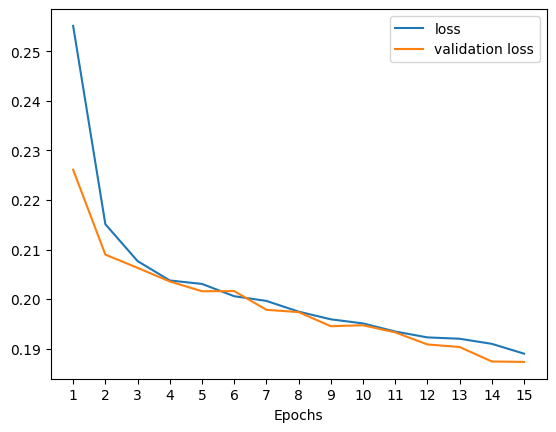

In [ ]:
plot_loss(train_history4, epochs)

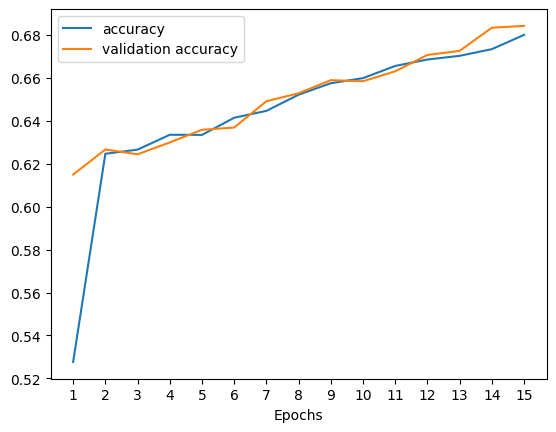

In [ ]:
plot_accuracy(train_history4, epochs)

In [ ]:
accuracy_bo ={
    "B0 accuracy": train_history['Train_loss'],
    "B0 val_accuracy": train_history['Test_loss'],
    "B1 accuracy": train_history1['Train_loss'],
    "B1 val_accuracy": train_history1['Test_loss'],
    "B2 accuracy": train_history2['Train_loss'],
    "B2 val_accuracy": train_history2['Test_loss'],
    "B3 accuracy": train_history3['Train_loss'],
    "B3 val_accuracy": train_history3['Test_loss'],
    "B4 accuracy": train_history4['Train_loss'],
    "B4 val_accuracy": train_history4['Test_loss'],
}

accuracy_bonus_compare = pd.DataFrame(accuracy_bo)
accuracy_bonus_compare

B0 accuracy  B0 val_accuracy  B1 accuracy  B1 val_accuracy  B2 accuracy  \
0      0.366873         0.174658     0.195331         0.071627     0.217394   
1      0.114585         0.041205     0.036789         0.013714     0.031107   
2      0.060301         0.017983     0.012287         0.007062     0.007636   
3      0.046739         0.009307     0.007141         0.004370     0.005238   
4      0.038297         0.005941     0.004433         0.005620     0.004853   
5      0.031671         0.006368     0.005285         0.002713     0.003739   
6      0.027114         0.003944     0.003509         0.005435     0.003047   
7      0.021810         0.002637     0.005429         0.003680     0.004759   
8      0.020104         0.001946     0.002583         0.002994     0.002340   
9      0.016710         0.002271     0.005444         0.004037     0.003574   
10     0.013907         0.002738     0.004033         0.001647     0.003401   
11     0.013914         0.002493     0.003403         0.007502     0.005768   
12     0.010421         0.001435     0.003301         0.004247     0.002192   
13     0.011297         0.002431     0.004237         0.004895     0.001263   
14     0.009001         0.003990     0.001524         0.006273     0.003046   

    B2 val_accuracy  B3 accuracy  B3 val_accuracy  B4 accuracy  \
0          0.072506     0.007112         0.000812     0.255139   
1          0.012722     0.008775         0.002834     0.215109   
2          0.004148     0.008808         0.001570     0.207668   
3          0.003448     0.006855         0.003838     0.203748   
4          0.004651     0.006174         0.001121     0.203052   
5          0.001674     0.008458         0.004047     0.200572   
6          0.001873     0.007936         0.001938     0.199622   
7          0.001670     0.007788         0.003365     0.197460   
8          0.002404     0.006881         0.001860     0.195907   
9          0.003140     0.005782         0.001809     0.195079   
10         0.001502     0.009795         0.004422     0.193439   
11         0.002484     0.005971         0.001412     0.192256   
12         0.005711     0.008262         0.002238     0.191984   
13         0.002104     0.006018         0.001313     0.190953   
14         0.005805     0.006412         0.003104     0.188971   

    B4 val_accuracy  
0          0.226109  
1          0.208970  
2          0.206298  
3          0.203552  
4          0.201572  
5          0.201604  
6          0.197827  
7          0.197359  
8          0.194514  
9          0.194706  
10         0.193270  
11         0.190830  
12         0.190309  
13         0.187392  
14         0.187304